In [31]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import galsim
from IPython.display import clear_output
from astropy.io import fits
from matplotlib.colors import LogNorm
from numpy import mgrid, sum
import scipy.linalg as alg
import scipy.stats as stats
from galsim.zernike import Zernike
import matplotlib

In [32]:
import sys
sys.path.append('/Users/zhangtianqing/Documents/Research/PSF_Rachel/HOMESim')
import homesm
import metasm

In [33]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [34]:
class shapeletXmoment:
    
    def __init__(self, psf,n, bmax = 10, pixel_scale = 1.0):
        self.n = n
        self.bmax = bmax
        self.pixel_scale = pixel_scale
        self.base_psf = psf
        self.base_psf_image = psf.drawImage(scale = pixel_scale)
        self.base_psf_result = galsim.hsm.FindAdaptiveMom(self.base_psf_image)
        self.base_shapelet = galsim.Shapelet.fit(self.base_psf_result.moments_sigma, bmax, self.base_psf_image, normalization = 'sb')
        self.base_bvec = self.base_shapelet.bvec
        
    def moment_measure(self, image, p, q):
        n = p+q
        
        if n<2:
            print( "Does not support moment measure less than second order.")
            return 0
        elif n==2:
            return self.get_second_moment(image,p,q)
        else:
            return self.higher_weighted_moment(image,p,q)
        
    def get_second_moment(self, image, p ,q):
        image_results = galsim.hsm.FindAdaptiveMom(image)
        if p==2:
            return image_results.observed_shape.e1
        elif q==2:
            return image_results.observed_shape.e2
        else:
            return image_results.moments_sigma
        
    def higher_weighted_moment(self,gsimage,p,q):
        
        image = gsimage.array
        

        y, x = mgrid[:image.shape[0],:image.shape[1]]+1

        psfresults = galsim.hsm.FindAdaptiveMom(galsim.Image(image, scale = self.pixel_scale))
        M = np.zeros((2,2))
        e1 = psfresults.observed_shape.e1
        e2 = psfresults.observed_shape.e2
        sigma4 = psfresults.moments_sigma**4
        c = (1+e1)/(1-e1)
        M[1][1] = np.sqrt(sigma4/(c-0.25*e2**2*(1+c)**2))
        M[0][0] = c*M[1][1]
        M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
        M[1][0] = M[0][1]

        pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
        pos = np.swapaxes(pos,0,1)
        pos = np.swapaxes(pos,1,2)


        inv_M = np.linalg.inv(M)
        sqrt_inv_M = alg.sqrtm(inv_M)
        std_pos = np.zeros(pos.shape)
        weight = np.zeros(pos.shape[0:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                this_pos = pos[i][j]
                this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
                std_pos[i][j] = this_standard_pos
                weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))

        std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]

        return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    def modify_pq(self, m, c, delta = 0.0001):
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)

        ori_moments = self.get_all_moments(self.base_psf_image, pq_list)
        
        A = np.zeros(shape =(mu, mu))
        
        #i is the mode index
        #j is the moment index
        #measure d_moment_j / d_mode_i
        
        for i in range(mu):
            
            mode_index = shapelet_list[i]
            
            pert_bvec = self.base_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale,method = 'no_pixel'), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - ori_moments[j])/delta     
        self.A = A


        dm = np.zeros(mu)
        dm += m*ori_moments + c
        ds = np.linalg.solve(A.T,dm)
        #print ds
        #print dm
        
        true_mod_bvec = self.base_bvec.copy()
        for i in range(mu):
            true_mod_bvec[shapelet_list[i]]+=ds[i]

        
        self.true_mod = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, true_mod_bvec)
        return self.true_mod
    
    def step_modify_pq(self,current_moments,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta, pq_list):
        
        A = np.zeros(shape =(mu, mu))

        
        for i in range(mu):
            mode_index = shapelet_list[i]
            
            pert_bvec = current_mod_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - current_moments[j])/delta     


        ds = np.linalg.solve(A.T,current_dm)
        
        for i in range(mu):
            current_mod_bvec[shapelet_list[i]]+=ds[i]
        return current_mod_bvec
            
    def iterative_modify_pq(self,m,c,delta = 0.0001, threshold = 1e-6):
        
        iterative_n = 10
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)
        base_shapelet_image = self.base_shapelet.drawImage(scale = self.pixel_scale)
        original_moment = self.get_all_moments(base_shapelet_image, pq_list)
        current_moment = self.get_all_moments(base_shapelet_image, pq_list)
        
        current_dm = np.zeros(mu)
        current_dm += m*current_moment + c
        
        destiny_moment = current_moment + current_dm
        
        current_mod_bvec = self.base_bvec.copy()
        current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
        
        while (np.max(np.abs(current_dm)) > threshold):
            
            current_mod_bvec = self.step_modify_pq(current_moment,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta,pq_list)
            current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
            current_moment = self.get_all_moments(current_psf.drawImage(scale = self.pixel_scale), pq_list)
            
            current_dm = destiny_moment - current_moment
            #print current_dm
            #print current_moment - original_moment
        return current_psf
                
    def get_all_moments(self, image, pq_list):
        results_list = []
        for tup in pq_list:
            results_list.append(self.moment_measure(image, tup[0], tup[1]))
                
        return np.array(results_list)
        
        
    def pq2mode(self,p,q):
        
        if p<=q:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)
        else:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)+1
        
        
        
    def pq2shapelet(self,pq_list):
        shapelet_index = []
        for tup in pq_list:
            shapelet_index.append(self.pq2mode(tup[0], tup[1]))
        return shapelet_index
        
        
        

        
        
    def get_mu(self, n):
        
        mu = 0
        for i in range(2,n+1):
            mu+=i+1
        return mu
    
    def get_pq_full(self,nmax):
        
        pq_list = []
        
        for n in range(2, nmax+1):
            p = 0
            q = n
            
            pq_list.append((p,q))
            
            while p<n:
                p+=1
                q-=1
                pq_list.append((p,q))
        return pq_list
    
    def get_pq_except(self,nmax,p,q):
        
        pq_full = self.get_pq_full(nmax)
        pq_except = []
        for tup in pq_full:
            if tup != (p,q):
                pq_except.append(tup)
                
        return pq_except
     
        

In [35]:


class HOMExShapeletPair:
    
    def __init__(self, gal_type, gal_sigma,e1,e2,g1,g2,psf_type,psf_sigma,
                gal_flux=1.e2,pixel_scale = 1.0,sersicn = -1,subtract_intersection = True,
                is_self_defined_PSF = False , self_defined_PSF=None, self_define_PSF_model = None,metacal_method = 'estimateShear', GREAT3 = False, 
                cosmic_shear = None, great3_ind = None, great3_cat = None,bpd_params = None):
        
        #Define basic variables
        self.pixel_scale = pixel_scale        
        self.subtract_intersection = subtract_intersection        
        self.is_self_defined_PSF = is_self_defined_PSF
        self.metacal_method = metacal_method

        
        #Define galaxy
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.gal_flux=gal_flux
        self.e1 = e1
        self.e2 = e2
        self.g1 = g1
        self.g2 = g2
        self.cosmic_shear = galsim.Shear(g1 = g1, g2 = g2)
        self.g = np.array([g1,g2])
        self.e = np.array([e1,e2])
        self.sersicn=sersicn
        self.e_truth = self.e
        
        self.bpd_params = bpd_params

#         if gal_type == "gaussian":
#             self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
#         elif gal_type == "sersic":
#             self.gal_light = self.findAdaptiveSersic(gal_sigma,sersicn)
        if gal_type == 'gaussian':
            gaussian_profile = galsim.Gaussian(sigma = gal_sigma)
            #gaussian_profile = self.toSize(gaussian_profile, self.gal_sigma,weighted = True)
            self.gal_light = gaussian_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
        elif gal_type == 'sersic':
            sersic_profile = galsim.Sersic(sersicn, half_light_radius = self.gal_sigma)
            #sersic_profile = self.toSize(sersic_profile, self.gal_sigma,weighted = True)
            self.gal_light = sersic_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)

        elif gal_type == 'bpd':
            bulge = galsim.Sersic(4, half_light_radius = self.bpd_params[0])
            bulge = bulge.shear(e1 = bpd_params[1], e2 = bpd_params[2])
            disk = galsim.Sersic(1, half_light_radius = self.bpd_params[3])
            disk = disk.shear(e1 = bpd_params[4], e2 = bpd_params[5])
            bulge_to_total = bpd_params[6]
            self.gal_light = bulge_to_total*bulge + (1-bulge_to_total)*disk

        self.gal_rotate_light = self.gal_light.rotate(90 * galsim.degrees)
        self.gal_light = self.gal_light.shear(g1 = g1, g2 = g2)
        self.gal_rotate_light = self.gal_rotate_light.shear(g1 = g1, g2 = g2)
        
        if not is_self_defined_PSF:
            self.psf_type = psf_type
            self.psf_sigma = psf_sigma
            self.psf_model_sigma = psf_sigma

          
            if psf_type == 'gaussian':
                self.psf_base = galsim.Gaussian(flux = 1.0, sigma = self.psf_sigma)
                #self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'kolmogorov':
                self.psf_base  = galsim.Kolmogorov(flux = 1.0, half_light_radius = 0.5)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
            elif psf_type == 'opticalPSF':
                self.psf_base = galsim.OpticalPSF(1.0,flux = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'sersic':
                self.psf_base = galsim.Sersic(psf_sersicn, half_light_radius = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
  
        else:
            self.psf_type = "self_define"
            truth_image = self_defined_PSF
            truth_psf = galsim.InterpolatedImage(truth_image,scale = pixel_scale)
            truth_measure = galsim.hsm.FindAdaptiveMom(truth_image)
            truth_sigma = truth_measure.moments_sigma
            self.psf_light = truth_psf
            
    def setup_shapelet_psf(self, m, c, n, bmax = 10):
        self.n = n
        self.sxm = shapeletXmoment(self.psf_base,n,pixel_scale = self.pixel_scale)
        self.psf_light = self.sxm.base_shapelet
        self.psf_model_light = self.sxm.iterative_modify_pq(m, c)
        self.dm = m*self.sxm.get_all_moments(self.sxm.base_psf_image, self.sxm.get_pq_full(n))+c


    def speed_setup_shapelet_psf(self,m,c,n, psf_light, psf_model_light, dm):
        self.n = n
        self.sxm = shapeletXmoment(self.psf_base,n,pixel_scale = self.pixel_scale)
        self.psf_light = psf_light
        self.psf_model_light = psf_model_light
        self.dm = dm
    
    
    def perc_bias(self,metacal = True):
        base_ori_r, base_ori_e = self.measure(metacal = metacal,rot = False, base = True)
        mod_ori_r, mod_ori_e = self.measure(metacal = metacal,rot = False, base = False)
        base_rot_r, base_rot_e = self.measure(metacal = metacal,rot = True, base = True)
        mod_rot_r, mod_rot_e = self.measure(metacal = metacal,rot = True, base = False)
        
        R_base = np.mean(np.array([base_ori_r,base_rot_r]),axis = 0).reshape(2,2)
        base_shape = np.mean(np.array([base_ori_e,base_rot_e]),axis = 0)
        g_base = np.matmul(np.linalg.inv(R_base),base_shape)
        
        R_mod = np.mean(np.array([mod_ori_r,mod_rot_r]),axis = 0).reshape(2,2)
        mod_shape = np.mean(np.array([mod_ori_e,mod_rot_e]),axis = 0)
        g_mod = np.matmul(np.linalg.inv(R_mod),mod_shape)
        #print (g_mod[0] - g_base[0])/self.g1
        self.abs_bias = (g_mod - g_base)
        return (g_mod - g_base)/self.g
        
    def measure(self,metacal=True,rot = False, base = False):
        if base:
            image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        else:
            image_epsf = self.psf_model_light.drawImage(scale=self.pixel_scale)
            
        if rot:
            galaxy = self.gal_rotate_light
        else:
            galaxy = self.gal_light
        
        final = galsim.Convolve([galaxy,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        if metacal == False:
            results = galsim.hsm.EstimateShear(image,image_epsf)
            shape = galsim.Shear(e1 = results.corrected_e1, e2 = results.corrected_e2)
            return np.array([[1.0,0,0,1.0]]),np.array([shape.g1,shape.g2])
        else:
            results = self.perform_metacal(image,image_epsf)
            return results["R"].reshape((-1)), results["noshear"]
        
    def perform_metacal(self,image,image_epsf):
        metacal = metasm.metacal_shear_measure(image,image_epsf,great3 = True)
        metacal.measure_shear(self.metacal_method)
        results = metacal.get_results()
        return results
    
    def findAdaptiveSersic(self,sigma,n):
        good_half_light_re = bisect(Sersic_sigma,sigma/3,sigma*5,args=(n,self.pixel_scale,sigma))
        return galsim.Sersic(n=n,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,max(self.psf_sigma/5,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,max(self.psf_sigma/3,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
    
    def toSize(self, profile, sigma , weighted = True, tol = 1e-4):


        if weighted:
            apply_pixel =  max(self.pixel_scale, sigma/10)
            true_sigma = galsim.hsm.FindAdaptiveMom(profile.drawImage(scale =apply_pixel,method = 'no_pixel')).moments_sigma*apply_pixel
        else:
            #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')

            
            image = profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
            true_sigma = image.calculateMomentRadius()

        ratio = sigma/true_sigma
        new_profile = profile.expand(ratio)

        while abs(true_sigma - sigma)>tol:
            ratio = sigma/true_sigma
            new_profile = new_profile.expand(ratio)

            if weighted:
                
                apply_pixel =  max(self.pixel_scale, sigma/10)
                true_sigma = galsim.hsm.FindAdaptiveMom(new_profile.drawImage(scale =apply_pixel,method = 'no_pixel'),hsmparams=galsim.hsm.HSMParams(max_mom2_iter = 2000)).moments_sigma*apply_pixel
            else:
                #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')
                image = new_profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
                true_sigma = image.calculateMomentRadius()
        return new_profile
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale,method = 'no_pixel')
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_actual_dm(self):
        m_truth = self.sxm.get_all_moments(self.psf_light.drawImage(scale=self.pixel_scale), self.sxm.get_pq_full(self.n))
        m_model = self.sxm.get_all_moments(self.psf_model_light.drawImage(scale=self.pixel_scale), self.sxm.get_pq_full(self.n))
        
        return m_model - m_truth
    
    def get_results(self,metacal = True):
        results = dict()
        
        results['shear_bias'] = self.perc_bias(metacal = metacal)
        results['abs_bias'] = self.abs_bias
        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        results["gal_sigma"] = self.gal_sigma
        results["psf_sigma"] = self.psf_sigma
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["e"] = self.e
        results["sersicn"] = self.sersicn
        results["gal_hlr"] = self.gal_light.calculateHLR()
        results["psf_hlr"] = self.psf_base.calculateHLR()
        results["psf_model_sigma"] = self.psf_model_sigma
        results['g'] = self.g
        results["dm"] = self.dm
        results["actual_dm"] = self.get_actual_dm()
        
        
        
        return results
    
    
    

In [36]:
def do_tests(tests,j,test_m, test_c,n):
    testsresult=[]
    for i in range(len(tests)):
        test = HOMExShapeletPair(*tests[i][:-1],**tests[i][-1])

        test.setup_shapelet_psf(test_m[i],test_c[i],n)

        results = test.get_results(metacal = False)
        testsresult.append(results)
        clear_output() 
        print ("Finished "+str(float((i+1))/len(tests)*100)+"%")
    return testsresult
    

In [37]:
def do_tests_speed(tests,j,test_m, test_c,n):
    testsresult=[]
    for i in range(len(tests)):
        test = HOMExShapeletPair(*tests[i][:-1],**tests[i][-1])
        if i!=0:
            test.speed_setup_shapelet_psf(test_m[i],test_c[i],n,psf_light, psf_model_light, dm)
        else:
            test.setup_shapelet_psf(test_m[i],test_c[i],n)
            psf_light = test.psf_light
            psf_model_light = test.psf_model_light
            dm = test.dm
        results = test.get_results(metacal = False)
        testsresult.append(results)
        #clear_output() 
        #print ("Finished "+str(float((i+1))/len(tests)*100)+"%")
    return testsresult
    

In [38]:
def e2(e1,e):
    return np.sqrt(e**2 - e1**2)

In [10]:
test1 = HOMExShapeletPair("gaussian", 3.0, 0.2, 0.2, 0.01, 0.01, "gaussian", 2.0)

In [11]:
m = np.zeros(12)
c = np.zeros(12)
c[9]+=0.001
test1.setup_shapelet_psf(m,c,4)
pqlist = test1.sxm.get_pq_full(6)[3:]


In [12]:
test1.sxm.get_pq_full(6)

[(0, 2),
 (1, 1),
 (2, 0),
 (0, 3),
 (1, 2),
 (2, 1),
 (3, 0),
 (0, 4),
 (1, 3),
 (2, 2),
 (3, 1),
 (4, 0),
 (0, 5),
 (1, 4),
 (2, 3),
 (3, 2),
 (4, 1),
 (5, 0),
 (0, 6),
 (1, 5),
 (2, 4),
 (3, 3),
 (4, 2),
 (5, 1),
 (6, 0)]

In [25]:
# test2_init = [("gaussian" ,3.98    ,0.28,0.28,1e-8,1e-8,"gaussian"  ,2.4,{'subtract_intersection':True}) for i in range(21)
# ]
test2_init = [("gaussian" ,0.85    ,0.28,0.28,1e-8,1e-8,"gaussian"  ,1.2,{'subtract_intersection':True}) for i in range(21)
]
test2_m = np.zeros(shape = (22,21,25))
test2_c = np.zeros(shape = (22,21,25))
for index in range(22):
    for i in range(21):
        test2_c[index][i][index+3]+=-0.01 + 0.001*i



In [26]:
test2result = []
for i in range(len(test2_m)):
    print( "Start tests for moment"+ str(i+4))
    test2result.append(do_tests(test2_init,i,test2_m[i],test2_c[i],6))
    #print test2result
%store test2result

Finished 14.285714285714285%


KeyboardInterrupt: 

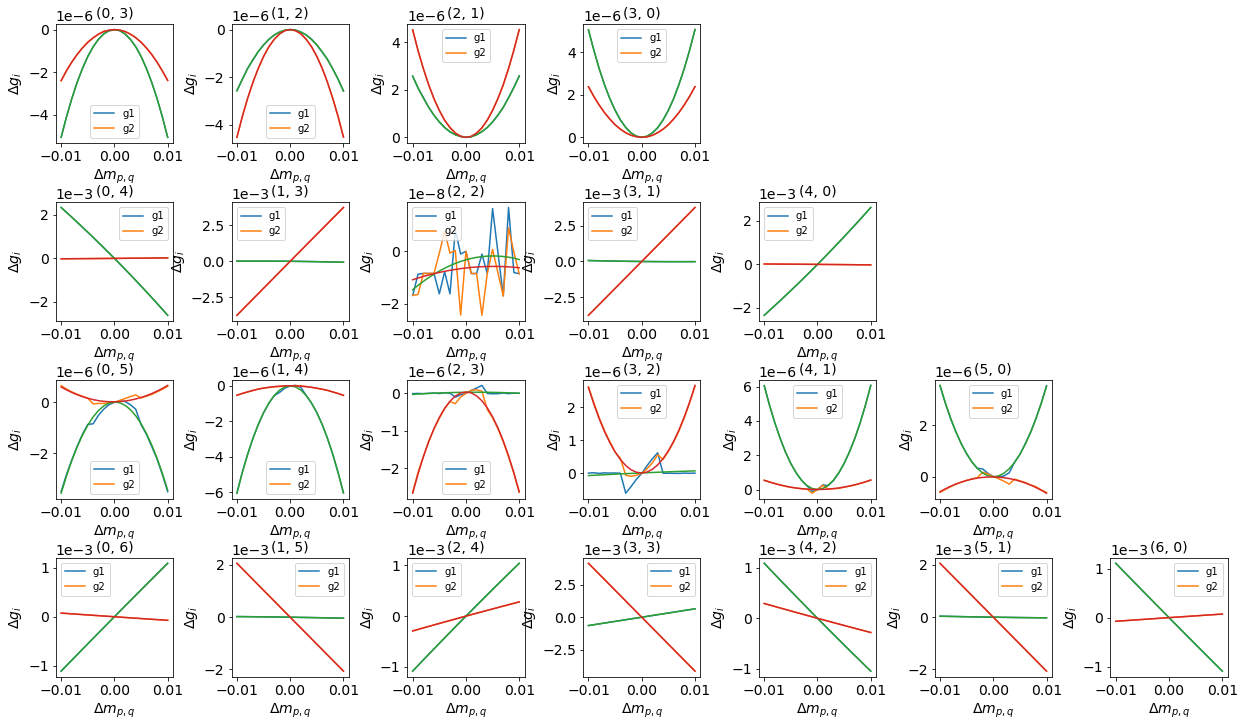

In [29]:
pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

param1_dir = {}
param2_dir = {}


for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    dm = np.array([t['dm'][j+3] for t in test2result[j]])
    dg1 = np.array([t["abs_bias"][0] for t in test2result[j]])
    dg2 = np.array([t["abs_bias"][1] for t in test2result[j]])
    
    params1= np.polyfit(dm,dg1,2)
    params2= np.polyfit(dm,dg2,2)
    
#     print params1
    
    
    plt.plot(dm,dg1,label='g1')
    plt.plot(dm,dg2,label='g2')

    dg1_project = params1[2] + dm*params1[1] + dm**2*params1[0]
    dg2_project = params2[2] + dm*params2[1] + dm**2*params2[0]
    
    
    plt.plot(dm,dg1_project)
    plt.plot(dm,dg2_project)
    
    param1_dir[(p,q)] = params1
    param2_dir[(p,q)] = params2
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    plt.xlabel(r"$\Delta m_{p,q}$")
    plt.ylabel(r'$\Delta g_i$')
    
    
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

In [26]:
import pickle


with open("../plots2/pickle/shear_response.pkl","wb") as f:
    pickle.dump([pqlist,test2result],f)




In [28]:
import pickle

with open("../plots2/pickle/shear_response.pkl","rb") as f:
    pqlist,test2result = pickle.load(f)


In [30]:
import pickle

f = open("../notebook/data/params1.pkl","wb")
pickle.dump(param1_dir,f)
f.close()

f = open("../notebook/data/params2.pkl","wb")
pickle.dump(param2_dir,f)
f.close()



In [13]:


HSC_moment_bias = np.load('data/mean_residual.npy')


In [14]:
#gal_size = 0.17 arcsec, psf_size = 0.24 arcsec, pixel_size = 0.2 arcsec
test3_init = [("gaussian" ,0.85    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,1.2 ,{'subtract_intersection':True}) for i in range(10)
]

# test3_init = [("gaussian" ,3.98    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,2.4 ,{'subtract_intersection':True}) for i in range(10)
# ]
test3_m = np.zeros(shape = (22,10,25))
test3_c = np.zeros(shape = (22,10,25))
for index in range(22):
    for i in range(10):
        test3_c[index][i][index+3]+=HSC_moment_bias[index+3]
        #test3_c[index][i][index+3]+=0.005



In [15]:
test3result = []
for i in range(len(test3_m)):
    print( "Start tests for moment"+ str(i+4))
    test3result.append(do_tests_speed(test3_init,i,test3_m[i],test3_c[i],6))
%store test3result
 

Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25
Stored 'test3result' (list)


In [31]:
import pickle


with open("../plots2/pickle/add_and_mul.pkl","wb") as f:
    pickle.dump([pqlist,test3result,test3_init],f)



(0, 3) (0.0006611746563208371, 7.949573940202151e-05) (-1.9698852497159392e-05, -1.1204575067017929e-05)
(1, 2) (-5.1370647651530134e-05, -4.214481339672524e-05) (8.9141427454346e-06, 1.5624472871067496e-06)
(2, 1) (0.00024240837988424716, 0.00013153771775501892) (-9.020985893837265e-06, -9.021856490025e-06)
(3, 0) (-1.3278567706666576e-05, 5.234156587950143e-05) (-2.1525160894449633e-06, -9.815278420588493e-06)
(0, 4) (0.6150206887932781, 0.430094976414882) (-0.07019819729947696, 0.0005548451912508925)
(1, 3) (0.0, 0.0) (0.0, 0.0)
(2, 2) (-0.0721579740652614, -0.19793408849531943) (2.8951802842164016e-06, 3.340482398288319e-06)
(3, 1) (-0.00013660848935224653, -0.0001567586990685226) (3.7861736547813627e-06, -0.00041297150723003856)
(4, 0) (0.8215738392082934, 0.5654966252093206) (0.09274511889977172, -0.0007602622534143769)
(0, 5) (0.0005417658913237925, -0.00014807449256647566) (9.084702160359434e-06, 2.0788325511000853e-05)
(1, 4) (4.093437871494586e-05, -6.133089188024742e-06) (9.

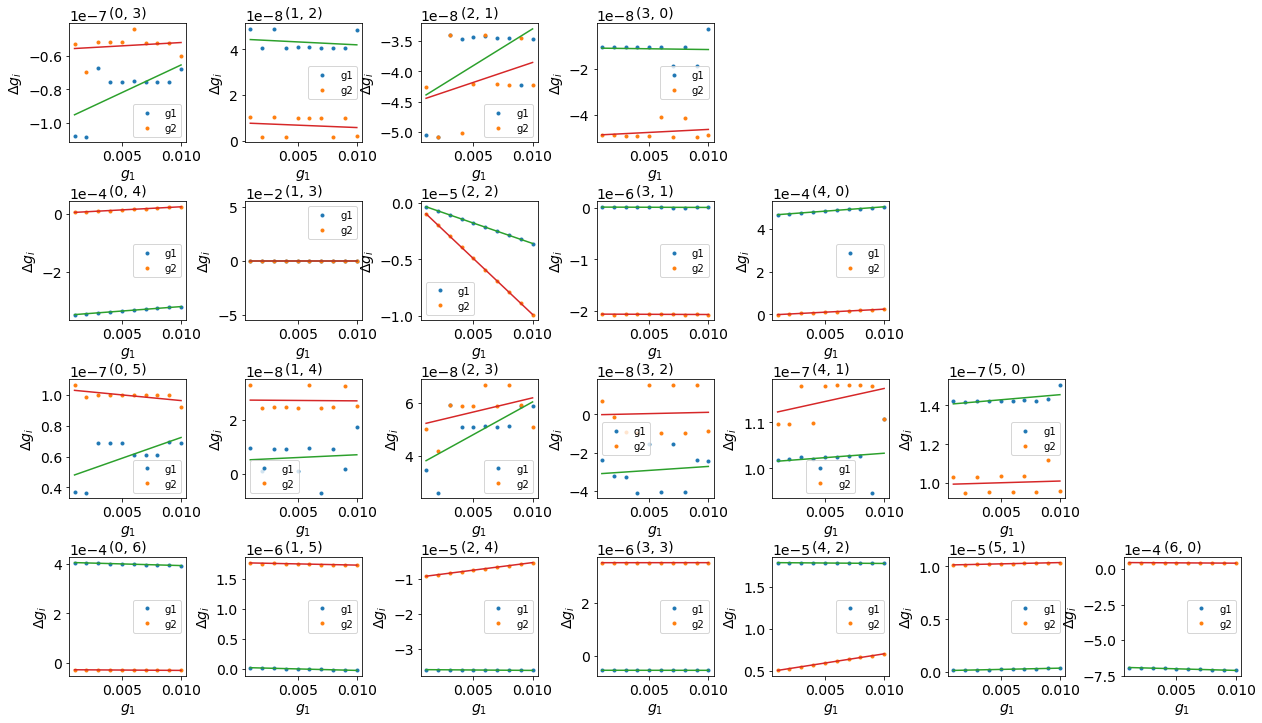

In [16]:
pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

g1_m = [];g1_c = [];g2_m = [];g2_c = []


for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    g1 = np.array([param[4] for param in test3_init])
    g2 = np.array([param[5] for param in test3_init])
    
    dg1 = np.array([t["abs_bias"][0] for t in test3result[j]])
    dg2 = np.array([t["abs_bias"][1] for t in test3result[j]])
    
    params1= np.polyfit(g1,dg1,1)
    params2= np.polyfit(g2,dg2,1)
    
    g1_m.append(params1[0]);g1_c.append(params1[1]);g2_m.append(params2[0]);g2_c.append(params2[1])
    
    #print params1,params2
    
    dg1_project = params1[1] + g1*params1[0] 
    dg2_project = params2[1] + g2*params2[0] 
    
    plt.plot(g1,dg1,'.',label='g1')
    plt.plot(g2,dg2,'.',label='g2')
    
    plt.plot(g1,dg1_project)
    plt.plot(g2,dg2_project)
    
    
    print(str((p,q)), (params1[0]/0.005, params2[0]/0.005), (params1[1]/0.005, params2[1]/0.005))
    
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    plt.xlabel(r"$g_1$")
    plt.ylabel(r'${\Delta g_i}$')
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

In [46]:




test4_init = [("gaussian" ,3.98    ,-0.2+i*0.04,e2(-0.2+i*0.04, 0.28),1e-8,1e-8,"gaussian"  ,2.4,{'subtract_intersection':True}) for i in range(5)
]
test4_m = np.zeros(shape = (22,5,25))
test4_c = np.zeros(shape = (22,5,25))
for index in range(22):
    for i in range(5):
        test4_c[index][i][index+3]+=0.005


In [10]:
test4result = []
for i in range(len(test4_m)):
    print "Start tests for moment"+ str(i+4)
    test4result.append(do_tests(test4_init,i,test4_m[i],test4_c[i],6))
%store test4result
 

Start tests for moment4
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment5
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment6
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment7
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment8
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment9
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment10
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment11
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment12
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100.0%
Start tests for moment13
Finished 20.0%
Finished 40.0%
Finished 60.0%
Finished 80.0%
Finished 100

In [17]:
print test4result[1]

[{'psf_model_sigma': 2.4, 'dm': array([0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]), 'e': array([-0.2       ,  0.19595918]), 'g': array([1.e-08, 1.e-08]), 'e1': -0.2, 'psf_type': 'gaussian', 'gal_sigma': 3.98, 'shear_bias': array([-1097.50990334,  -109.05607168]), 'sersicn': -1, 'actual_dm': array([-4.74082107e-09,  0.00000000e+00, -3.94785282e-09,  2.21896708e-09,
        4.99999871e-03,  5.23779187e-10, -4.06675720e-09,  5.34209244e-09,
       -2.21864574e-09,  3.96059072e-09, -2.54273000e-10,  8.90242657e-09,
        7.64080583e-09, -3.17790055e-09,  1.12130332e-09, -2.87395057e-09,
        1.37083055e-09, -1.34789970e-08,  7.70216468e-09, -1.27018555e-08,
        7.32859712e-09, -4.62298034e-09,  7.62367092e-09,  7.12220920e-11,
        1.82244870e-08]), 'e2': 0.19595917942265426, 'abs_bias': array([-1.09750990e-05, -1.09056072e-06]), 'psf

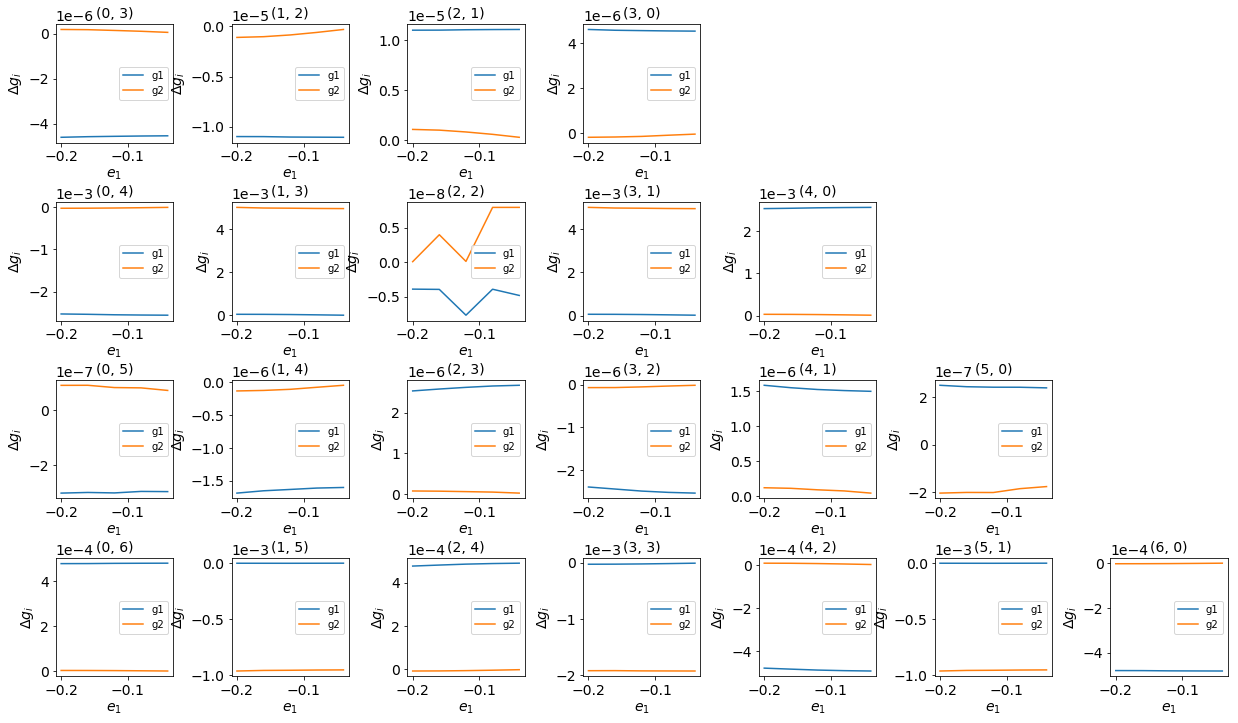

In [103]:
pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

param1_dir = {}
param2_dir = {}


for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    e1  = np.array([t['e1'] for t in test4result[j]])
    dg1 = np.array([t["abs_bias"][0] for t in test4result[j]])
    dg2 = np.array([t["abs_bias"][1] for t in test4result[j]])

    
    
    plt.plot(e1,dg1,label='g1')
    plt.plot(e1,dg2,label='g2')


    #print te bvst4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    plt.xlabel(r"$ e_1$")
    plt.ylabel(r'$\Delta g_i$')
    
    
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

$g(x) = (1+m_1(x)+m_2(x)+\dots)g_{true}(x)$

$<g(x) g(x+\theta)> = <((1+m_1(x)+m_2(x)+\dots)g_{true}(x))((1+m_1(x+\theta)+m_2(x+\theta)+\dots)g_{true}(x+\theta))>$
$= <g_{true}(x)g_{true}(x+\theta)> + <(m_1(x)+m_2(x)+\dots)g_{true}(x) g_{true}(x+\theta)> + <(m_1(x+\theta)+m_2(x+\theta)+\dots)g_{true}(x)g_{true}(x+\theta)>$
$= \xi_{true} + 2 \sum_i < m_i(x)> \xi_{true}$

m1 = 0.0032264223663343405
m2 = 0.003925618119574374


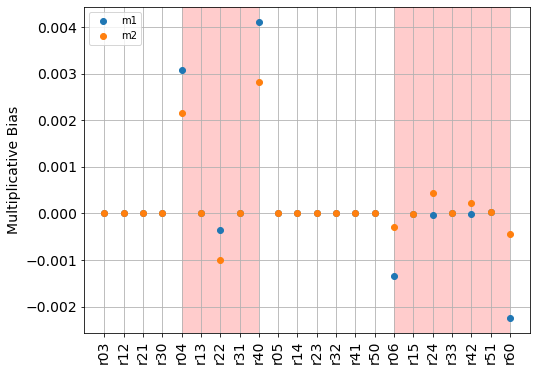

In [18]:
nob = 50

label_list = []
pqlist = test1.sxm.get_pq_full(6)
for i in range(nob):
    if i < 25:
        i_pre = 't'
        
    else:
        i_pre = 'r'
        
    
    label1 = i_pre+str(pqlist[i%25][0])+str(pqlist[i%25][1])
    label_list.append(label1)

fig, ax = plt.subplots(1,1,figsize=(8, 6)) 
ax.plot(np.arange(3,25),g1_m,'o',label = 'm1')
ax.plot(np.arange(3,25),g2_m,'o',label = 'm2')

ax.axvspan(7, 11, color='r', alpha=0.2, lw=0)

ax.axvspan(18, 24, color='r', alpha=0.2, lw=0)


ax.set_xticks(np.arange(3,25,1))
ax.set_xticklabels(label_list[28:], rotation='vertical', fontsize=14)

plt.grid()
plt.legend()
plt.ylabel("Multiplicative Bias")




print( "m1 = " + str(np.sum(g1_m)))
print( "m2 = " + str(np.sum(g2_m)))

c1 = -0.00018987422067592396
c2 = 2.6994452175891734e-05


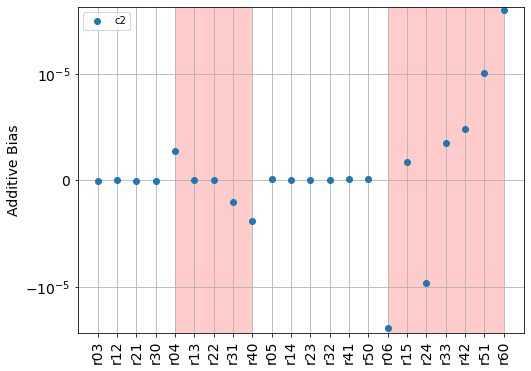

In [24]:

fig, ax = plt.subplots(1,1,figsize=(8, 6)) 
#ax.plot(np.arange(3,25),g1_c,'o',label = 'c1')
ax.plot(np.arange(3,25),g2_c,'o',label = 'c2')

ax.axvspan(7, 11, color='r', alpha=0.2, lw=0)

ax.axvspan(18, 24, color='r', alpha=0.2, lw=0)

ax.set_xticks(np.arange(3,25,1))
ax.set_xticklabels(label_list[28:], rotation='vertical', fontsize=14)

plt.grid()
plt.legend()
plt.ylabel("Additive Bias")
plt.yscale('symlog', linthresh = 0.00001)




print( "c1 = " + str(np.sum(g1_c)))
print( "c2 = " + str(np.sum(g2_c)))

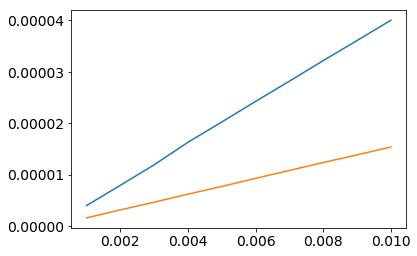

In [62]:
g = [param[4] for param in test3_init]
dg1 = np.array([t["abs_bias"][0] for t in test3result[4]])+2*np.array([t["abs_bias"][0] for t in test3result[6]])+np.array([t["abs_bias"][0] for t in test3result[8]])
dg2 = np.array([t["abs_bias"][1] for t in test3result[4]])+2*np.array([t["abs_bias"][1] for t in test3result[6]])+np.array([t["abs_bias"][1] for t in test3result[8]])


plt.plot(g,dg1)
plt.plot(g,dg2)




In [62]:
#change coma1 
#d(trefoil1) = du^3 - 3 d(uv^2) = 0
#d(coma1) = 0.04


test51_init = [("gaussian" ,3.0    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,2.0,{'subtract_intersection':True}) for i in range(10)
]
test51_m = np.zeros(shape = (10,12))
test51_c = np.zeros(shape = (10,12))
for i in range(test51_c.shape[0]):
    test51_c[i][6]+=0.03
    test51_c[i][4]+=0.01

test51result = []
for i in range(len(test51_m)):
    test = HOMExShapeletPair(*test51_init[i][:-1],**test51_init[i][-1])
    test.setup_shapelet_psf(test51_m[i],test51_c[i],4)
    results = test.get_results()
    test51result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test51_m)*100)+"%")


Finished 100.0%


In [64]:
#change coma2
#d(trefoil2) = 3d(u^2 v) - d(v^3) = 0
#d(coma1) = 0.04

test52_init = [("gaussian" ,3.0    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test52_m = np.zeros(shape = (10,12))
test52_c = np.zeros(shape = (10,12))
for i in range(test52_c.shape[0]):
    test52_c[i][5]+=0.01
    test52_c[i][3]+=0.03

test52result = []
for i in range(len(test52_m)):
    test = HOMExShapeletPair(*test52_init[i][:-1],**test52_init[i][-1])
    test.setup_shapelet_psf(test52_m[i],test52_c[i],4)
    results = test.get_results()
    test52result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test52_m)*100)+"%")


Finished 100.0%


In [65]:
#change trefoil1 
#d(coma1) = du^3 + d(uv^2) = 0
#d(coma1) = 0.04


test53_init = [("gaussian" ,3.0    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test53_m = np.zeros(shape = (10,12))
test53_c = np.zeros(shape = (10,12))
for i in range(test53_c.shape[0]):
    test53_c[i][6]+=0.01
    test53_c[i][4]-=0.01

test53result = []
for i in range(len(test53_m)):
    test = HOMExShapeletPair(*test53_init[i][:-1],**test53_init[i][-1])
    test.setup_shapelet_psf(test53_m[i],test53_c[i],4)
    results = test.get_results()
    test53result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test53_m)*100)+"%")


Finished 100.0%


In [67]:
#change trefoil2
#d(coma2) = d(u^2 v) - d(v^3) = 0
#d(coma1) = 0.04


test54_init = [("gaussian" ,3.0    ,0.28,0.28,0.001+0.001*i,0.001+0.001*i,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test54_m = np.zeros(shape = (10,12))
test54_c = np.zeros(shape = (10,12))
for i in range(test54_c.shape[0]):
    test54_c[i][5]+=0.01
    test54_c[i][3]-=0.01

test54result = []
for i in range(len(test54_m)):
    test = HOMExShapeletPair(*test54_init[i][:-1],**test54_init[i][-1])
    test.setup_shapelet_psf(test54_m[i],test54_c[i],4)
    results = test.get_results()
    test54result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test54_m)*100)+"%")


Finished 100.0%


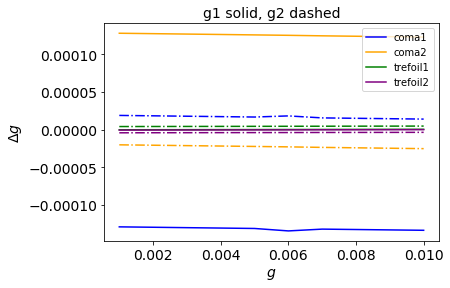

In [68]:
plt.plot([param[4] for param in test51_init],np.array([t["abs_bias"][0] for t in test51result]),label='coma1', color = 'blue')
plt.plot([param[5] for param in test51_init],np.array([t["abs_bias"][1] for t in test51result]),'-.', color = 'blue')
plt.plot([param[4] for param in test52_init],np.array([t["abs_bias"][0] for t in test52result]),label='coma2', color = 'orange')
plt.plot([param[5] for param in test52_init],np.array([t["abs_bias"][1] for t in test52result]),'-.', color = 'orange')
plt.plot([param[4] for param in test53_init],np.array([t["abs_bias"][0] for t in test53result]),label='trefoil1', color = 'green')
plt.plot([param[5] for param in test53_init],np.array([t["abs_bias"][1] for t in test53result]),'-.',color = 'green')
plt.plot([param[4] for param in test54_init],np.array([t["abs_bias"][0] for t in test54result]),label='trefoil2',color = 'purple')
plt.plot([param[5] for param in test54_init],np.array([t["abs_bias"][1] for t in test54result]),'-.',color = 'purple')
plt.xlabel(r'$g$')
plt.ylabel(r'$\Delta g$')
plt.title('g1 solid, g2 dashed')
plt.legend()

In [69]:
test61_init = [("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0+0.5*i,{'subtract_intersection':True}) for i in range(20)
]
test61_m = np.zeros(shape = (20,12))
test61_c = np.zeros(shape = (20,12))
for i in range(test61_c.shape[0]):
    test61_c[i][6]+=0.03
    test61_c[i][4]+=0.01

test61result = []
for i in range(len(test61_m)):
    test = HOMExShapeletPair(*test61_init[i][:-1],**test61_init[i][-1])
    test.setup_shapelet_psf(test61_m[i],test61_c[i],4)
    results = test.get_results()
    test61result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test61_m)*100)+"%")


Finished 100.0%


In [70]:
test62_init = [("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0+0.5*i,{'subtract_intersection':True}) for i in range(20)
]
test62_m = np.zeros(shape = (20,12))
test62_c = np.zeros(shape = (20,12))
for i in range(test62_c.shape[0]):
    test62_c[i][5]+=0.01
    test62_c[i][3]+=0.03

test62result = []
for i in range(len(test62_m)):
    test = HOMExShapeletPair(*test62_init[i][:-1],**test62_init[i][-1])
    test.setup_shapelet_psf(test62_m[i],test62_c[i],4)
    results = test.get_results()
    test62result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test62_m)*100)+"%")


Finished 100.0%


In [71]:
test63_init = [("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0+0.5*i,{'subtract_intersection':True}) for i in range(20)
]
test63_m = np.zeros(shape = (20,12))
test63_c = np.zeros(shape = (20,12))
for i in range(test63_c.shape[0]):
    test63_c[i][6]+=0.01
    test63_c[i][4]-=0.01

test63result = []
for i in range(len(test63_m)):
    test = HOMExShapeletPair(*test63_init[i][:-1],**test63_init[i][-1])
    test.setup_shapelet_psf(test63_m[i],test63_c[i],4)
    results = test.get_results()
    test63result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test63_m)*100)+"%")


Finished 100.0%


In [72]:
test64_init = [("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0+0.5*i,{'subtract_intersection':True}) for i in range(20)
]
test64_m = np.zeros(shape = (20,12))
test64_c = np.zeros(shape = (20,12))
for i in range(test64_c.shape[0]):
    test64_c[i][5]+=0.01
    test64_c[i][3]-=0.01

test64result = []
for i in range(len(test64_m)):
    test = HOMExShapeletPair(*test64_init[i][:-1],**test64_init[i][-1])
    test.setup_shapelet_psf(test64_m[i],test64_c[i],4)
    results = test.get_results()
    test64result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test64_m)*100)+"%")


Finished 100.0%


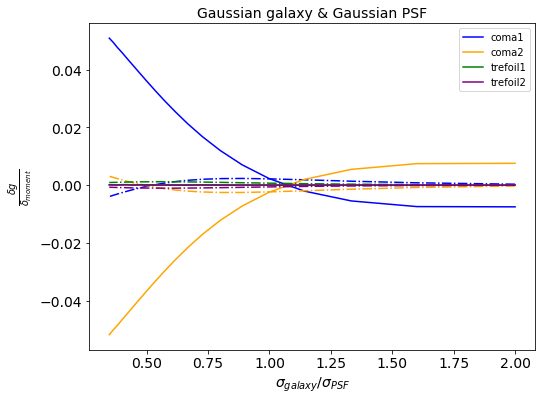

In [75]:
plt.figure(figsize = (8,6))

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test61result],np.array([ t["abs_bias"][0]/0.02 for t in test61result]),label = 'coma1',color = 'blue')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test61result],np.array([ t["abs_bias"][1]/0.02 for t in test61result]),'-.',color = 'blue')

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test62result],np.array([ t["abs_bias"][0]/0.02 for t in test62result]),label = 'coma2',color = 'orange')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test62result],np.array([ t["abs_bias"][1]/0.02 for t in test62result]),'-.',color = 'orange')

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test63result],np.array([ t["abs_bias"][0]/0.02 for t in test63result]),label = 'trefoil1',color = 'green')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test63result],np.array([ t["abs_bias"][1]/0.02 for t in test63result]),'-.',color = 'green')

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test64result],np.array([ t["abs_bias"][0]/0.02 for t in test64result]),label = 'trefoil2',color = 'purple')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test64result],np.array([ t["abs_bias"][1]/0.02 for t in test64result]),'-.',color = 'purple')

plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\frac{\delta g}{\delta_{moment}}$')

plt.title('Gaussian galaxy & Gaussian PSF')

plt.legend()

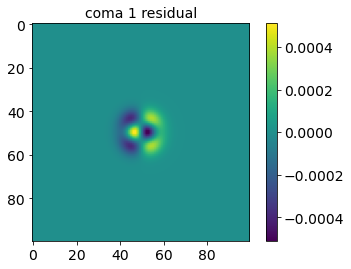

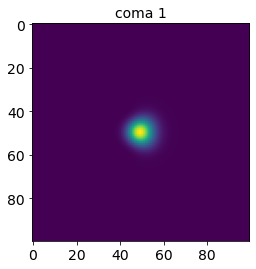

In [39]:
test71_init = ("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,4.0,{'subtract_intersection':True}) 
test71_m = np.zeros(shape = (1,12))
test71_c = np.zeros(shape = (1,12))

test71_c[0][6]+=0.03
test71_c[0][4]+=0.03

test = HOMExShapeletPair(*test71_init[:-1],**test71_init[-1])
test.setup_shapelet_psf(test71_m[0],test71_c[0],4)
truth = test.psf_light
model = test.psf_model_light

residual = model.drawImage(scale = 1.0, nx = 100, ny = 100).array - truth.drawImage(scale = 1.0, nx = 100, ny = 100).array



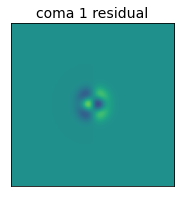

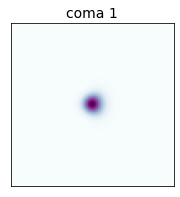

In [51]:

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])

plt.title('coma 1 residual')
plt.imshow(residual, vmin = -0.001, vmax = 0.001)
#plt.colorbar()
plt.show()

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(model.drawImage(scale = 1.0, nx = 100, ny = 100).array, cmap=plt.cm.BuPu)
plt.title('coma 1')
#plt.colorbar()
plt.show()



In [54]:
test72_init = ("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,4.0,{'subtract_intersection':True}) 
test72_m = np.zeros(shape = (1,12))
test72_c = np.zeros(shape = (1,12))

test72_c[0][3]+=0.03
test72_c[0][5]+=0.03

test = HOMExShapeletPair(*test72_init[:-1],**test72_init[-1])
test.setup_shapelet_psf(test72_m[0],test72_c[0],4)
truth = test.psf_light
model = test.psf_model_light

residual = model.drawImage(scale = 1.0, nx = 100, ny = 100).array - truth.drawImage(scale = 1.0, nx = 100, ny = 100).array



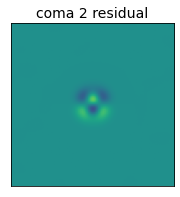

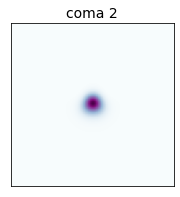

In [59]:

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(residual, vmin = -0.001, vmax = 0.001)
plt.title('coma 2 residual')
plt.show()

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(model.drawImage(scale = 1.0, nx = 100, ny = 100).array, cmap=plt.cm.BuPu)
plt.title('coma 2')
#plt.colorbar()
plt.show()


In [60]:
test73_init = ("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,4.0,{'subtract_intersection':True}) 
test73_m = np.zeros(shape = (1,12))
test73_c = np.zeros(shape = (1,12))

test73_c[0][6]+=0.02
test73_c[0][4]-=0.06

test = HOMExShapeletPair(*test73_init[:-1],**test73_init[-1])
test.setup_shapelet_psf(test73_m[0],test73_c[0],4)
truth = test.psf_light
model = test.psf_model_light

residual = model.drawImage(scale = 1.0, nx = 100, ny = 100).array - truth.drawImage(scale = 1.0, nx = 100, ny = 100).array



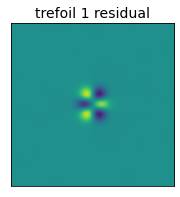

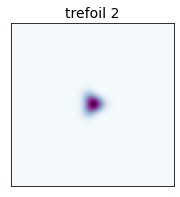

In [61]:

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(residual, vmin = -0.001, vmax = 0.001)
plt.title('trefoil 1 residual')
plt.show()

fig,ax = plt.subplots(figsize = (3,3))
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(model.drawImage(scale = 1.0, nx = 100, ny = 100).array, cmap=plt.cm.BuPu)
plt.title('trefoil 2')
#plt.colorbar()
plt.show()


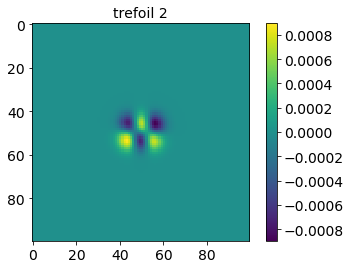

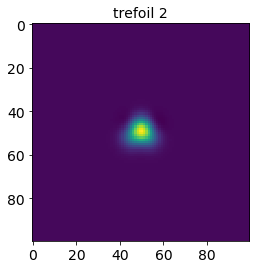

In [70]:
test74_init = ("gaussian" ,4.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,4.0,{'subtract_intersection':True}) 
test74_m = np.zeros(shape = (1,12))
test74_c = np.zeros(shape = (1,12))

test74_c[0][6]-=0.02
test74_c[0][5]+=0.06

test = HOMExShapeletPair(*test74_init[:-1],**test74_init[-1])
test.setup_shapelet_psf(test74_m[0],test74_c[0],4)
truth = test.psf_light
model = test.psf_model_light

residual = model.drawImage(scale = 1.0, nx = 100, ny = 100).array - truth.drawImage(scale = 1.0, nx = 100, ny = 100).array

plt.imshow(residual)
plt.title('trefoil 2')
plt.colorbar()
plt.show()

plt.imshow(model.drawImage(scale = 1.0, nx = 100, ny = 100).array)
plt.title('trefoil 2')
#plt.colorbar()
plt.show()



In [88]:
test81_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test81_m = np.zeros(shape = (10,12))
test81_c = np.zeros(shape = (10,12))
for i in range(test81_c.shape[0]):
    test81_c[i][4]+=0.001*i

test81result = []
for i in range(len(test81_m)):
    test = HOMExShapeletPair(*test81_init[i][:-1],**test81_init[i][-1])
    test.setup_shapelet_psf(test81_m[i],test81_c[i],4)
    results = test.get_results()
    test81result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test81_m)*100)+"%")


Finished 100.0%


In [89]:
test82_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test82_m = np.zeros(shape = (10,12))
test82_c = np.zeros(shape = (10,12))
for i in range(test82_c.shape[0]):
    test82_c[i][6]+=0.001*i

test82result = []
for i in range(len(test81_m)):
    test = HOMExShapeletPair(*test82_init[i][:-1],**test82_init[i][-1])
    test.setup_shapelet_psf(test82_m[i],test82_c[i],4)
    results = test.get_results()
    test82result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test82_m)*100)+"%")


Finished 100.0%


In [90]:
test83_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test83_m = np.zeros(shape = (10,12))
test83_c = np.zeros(shape = (10,12))
for i in range(test83_c.shape[0]):
    test83_c[i][4]+=0.001*i
    test83_c[i][6]+=0.001*i

test83result = []
for i in range(len(test83_m)):
    test = HOMExShapeletPair(*test83_init[i][:-1],**test83_init[i][-1])
    test.setup_shapelet_psf(test83_m[i],test83_c[i],4)
    results = test.get_results()
    test83result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test83_m)*100)+"%")


Finished 100.0%


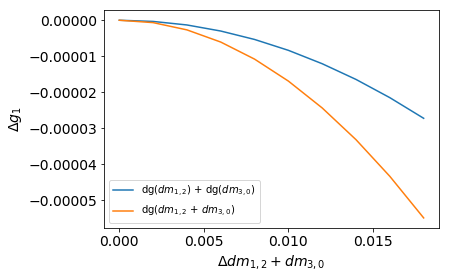

In [91]:
dm1 = [t['dm'][4] for t in test81result]
dm2 = [t['dm'][6] for t in test82result]
dmtot = np.array(dm1)+np.array(dm2)

dshear1 = [t['abs_bias'][0] for t in test81result]
dshear2 = [t['abs_bias'][0] for t in test82result]
dsheartot = np.array(dshear1)+np.array(dshear2)

plt.plot(dmtot, dsheartot, label = 'dg('+r"$dm_{1,2}$"+') + dg('+r"$dm_{3,0}$"+')')
plt.plot(dmtot, [t['abs_bias'][0] for t in test83result],label = 'dg('+r"$dm_{1,2}$"+' + '+r"$dm_{3,0}$"+')')
plt.ylabel(r'$\Delta g_1$')
plt.xlabel(r'$\Delta dm_{1,2} + dm_{3,0} $')
plt.legend()

In [44]:
test91_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test91_m = np.zeros(shape = (10,12))
test91_c = np.zeros(shape = (10,12))
for i in range(test91_c.shape[0]):
    test91_c[i][7]+=0.001*i

test91result = []
for i in range(len(test91_m)):
    test = HOMExShapeletPair(*test91_init[i][:-1],**test91_init[i][-1])
    test.setup_shapelet_psf(test91_m[i],test91_c[i],4)
    results = test.get_results()
    test91result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test91_m)*100)+"%")


Finished 100.0%


In [45]:
test92_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test92_m = np.zeros(shape = (10,12))
test92_c = np.zeros(shape = (10,12))
for i in range(test92_c.shape[0]):
    test92_c[i][8]+=0.001*i

test92result = []
for i in range(len(test92_m)):
    test = HOMExShapeletPair(*test92_init[i][:-1],**test92_init[i][-1])
    test.setup_shapelet_psf(test92_m[i],test92_c[i],4)
    results = test.get_results()
    test92result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test92_m)*100)+"%")


Finished 100.0%


In [46]:
test93_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test93_m = np.zeros(shape = (10,12))
test93_c = np.zeros(shape = (10,12))
for i in range(test93_c.shape[0]):
    test93_c[i][7]+=0.001*i
    test93_c[i][8]+=0.001*i

test93result = []
for i in range(len(test93_m)):
    test = HOMExShapeletPair(*test93_init[i][:-1],**test93_init[i][-1])
    test.setup_shapelet_psf(test93_m[i],test93_c[i],4)
    results = test.get_results()
    test93result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test93_m)*100)+"%")


Finished 100.0%


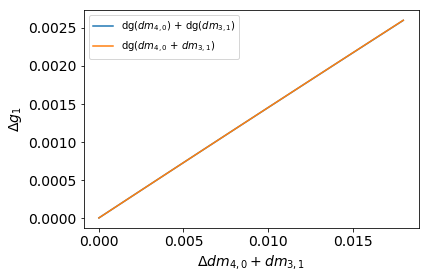

In [65]:
dm1 = [t['dm'][7] for t in test91result]
dm2 = [t['dm'][8] for t in test92result]
dmtot = np.array(dm1)+np.array(dm2)

dshear1 = [t['abs_bias'][0] for t in test91result]
dshear2 = [t['abs_bias'][0] for t in test92result]
dsheartot = np.array(dshear1)+np.array(dshear2)

plt.plot(dmtot, dsheartot, label = 'dg('+r"$dm_{4,0}$"+') + dg('+r"$dm_{3,1}$"+')')
plt.plot(dmtot, [t['abs_bias'][0] for t in test93result],label = 'dg('+r"$dm_{4,0}$"+' + '+r"$dm_{3,1}$"+')')

plt.ylabel(r'$\Delta g_1$')
plt.xlabel(r'$\Delta dm_{4,0} + dm_{3,1} $')
plt.legend()

In [83]:
test101_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test101_m = np.zeros(shape = (10,12))
test101_c = np.zeros(shape = (10,12))
for i in range(test101_c.shape[0]):
    test101_c[i][3]+=0.003*i

test101result = []
for i in range(len(test101_m)):
    test = HOMExShapeletPair(*test101_init[i][:-1],**test101_init[i][-1])
    test.setup_shapelet_psf(test101_m[i],test101_c[i],4)
    results = test.get_results()
    test101result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test101_m)*100)+"%")


Finished 100.0%


In [84]:
test102_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test102_m = np.zeros(shape = (10,12))
test102_c = np.zeros(shape = (10,12))
for i in range(test102_c.shape[0]):
    test102_c[i][8]+=0.001*i

test102result = []
for i in range(len(test102_m)):
    test = HOMExShapeletPair(*test102_init[i][:-1],**test102_init[i][-1])
    test.setup_shapelet_psf(test102_m[i],test102_c[i],4)
    results = test.get_results()
    test102result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test102_m)*100)+"%")


Finished 100.0%


In [85]:
test103_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test103_m = np.zeros(shape = (10,12))
test103_c = np.zeros(shape = (10,12))
for i in range(test103_c.shape[0]):
    test103_c[i][8]+=0.001*i
    test101_c[i][3]+=0.003*i

test103result = []
for i in range(len(test103_m)):
    test = HOMExShapeletPair(*test103_init[i][:-1],**test103_init[i][-1])
    test.setup_shapelet_psf(test103_m[i],test103_c[i],4)
    results = test.get_results()
    test103result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test103_m)*100)+"%")


Finished 100.0%


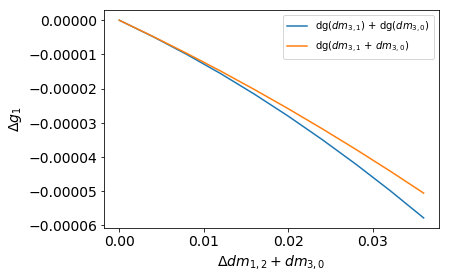

In [87]:
dm1 = [t['dm'][3] for t in test101result]
dm2 = [t['dm'][8] for t in test102result]
dmtot = np.array(dm1)+np.array(dm2)

dshear1 = [t['abs_bias'][0] for t in test101result]
dshear2 = [t['abs_bias'][0] for t in test102result]
dsheartot = np.array(dshear1)+np.array(dshear2)

plt.plot(dmtot, dsheartot, label = 'dg('+r"$dm_{3,1}$"+') + dg('+r"$dm_{3,0}$"+')')
plt.plot(dmtot, [t['abs_bias'][0] for t in test103result],label = 'dg('+r"$dm_{3,1}$"+' + '+r"$dm_{3,0}$"+')')
plt.ylabel(r'$\Delta g_1$')
plt.xlabel(r'$\Delta dm_{1,2} + dm_{3,0} $')
plt.legend()

In [113]:
test111_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test111_m = np.zeros(shape = (10,25))
test111_c = np.zeros(shape = (10,25))
for i in range(test111_c.shape[0]):
    test111_c[i][13]+=0.001*i

test111result = []
for i in range(len(test111_m)):
    test = HOMExShapeletPair(*test111_init[i][:-1],**test111_init[i][-1])
    test.setup_shapelet_psf(test111_m[i],test111_c[i],6)
    results = test.get_results()
    test111result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test111_m)*100)+"%")


Finished 100.0%


In [114]:
test112_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test112_m = np.zeros(shape = (10,25))
test112_c = np.zeros(shape = (10,25))
for i in range(test112_c.shape[0]):
    test112_c[i][19]+=0.001*i

test112result = []
for i in range(len(test112_m)):
    test = HOMExShapeletPair(*test112_init[i][:-1],**test112_init[i][-1])
    test.setup_shapelet_psf(test112_m[i],test112_c[i],6)
    results = test.get_results()
    test112result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test112_m)*100)+"%")


Finished 100.0%


In [115]:
test113_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test113_m = np.zeros(shape = (10,25))
test113_c = np.zeros(shape = (10,25))
for i in range(test113_c.shape[0]):
    test113_c[i][19]+=0.001*i
    test113_c[i][13]+=0.001*i


test113result = []
for i in range(len(test113_m)):
    test = HOMExShapeletPair(*test113_init[i][:-1],**test113_init[i][-1])
    test.setup_shapelet_psf(test113_m[i],test113_c[i],6)
    results = test.get_results()
    test113result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test113_m)*100)+"%")


Finished 100.0%


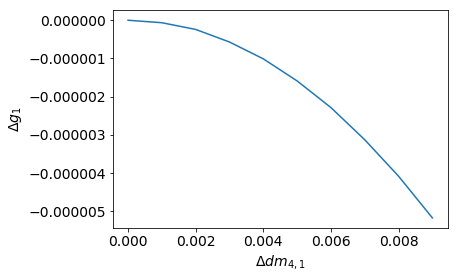

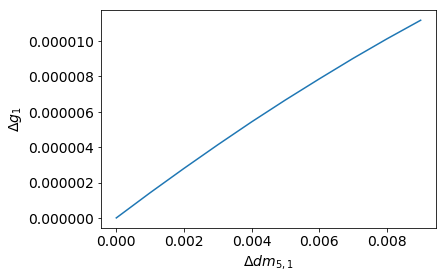

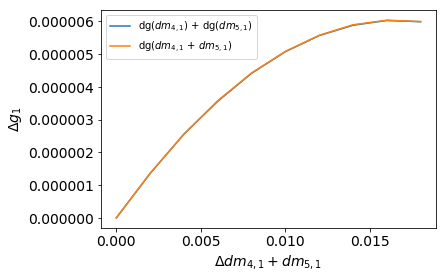

In [118]:
dm1 = [t['dm'][13] for t in test111result]
dm2 = [t['dm'][19] for t in test112result]
dmtot = np.array(dm1)+np.array(dm2)

dshear1 = [t['abs_bias'][0] for t in test111result]
dshear2 = [t['abs_bias'][0] for t in test112result]
dsheartot = np.array(dshear1)+np.array(dshear2)


plt.plot(dm1, dshear1)
plt.xlabel(r'$\Delta dm_{4,1} $')
plt.ylabel(r'$\Delta g_1$')

plt.show()

plt.plot(dm2, dshear2)
plt.xlabel(r'$\Delta dm_{5,1} $')
plt.ylabel(r'$\Delta g_1$')


plt.show()

plt.plot(dmtot, dsheartot, label = 'dg('+r"$dm_{4,1}$"+') + dg('+r"$dm_{5,1}$"+')')
plt.plot(dmtot, [t['abs_bias'][0] for t in test113result],label = 'dg('+r"$dm_{4,1}$"+' + '+r"$dm_{5,1}$"+')')
plt.ylabel(r'$\Delta g_1$')
plt.xlabel(r'$\Delta dm_{4,1} + dm_{5,1} $')
plt.legend()
plt.show()

In [119]:
test121_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test121_m = np.zeros(shape = (10,25))
test121_c = np.zeros(shape = (10,25))
for i in range(test121_c.shape[0]):
    test111_c[i][3]+=0.001*i

test121result = []
for i in range(len(test121_m)):
    test = HOMExShapeletPair(*test121_init[i][:-1],**test121_init[i][-1])
    test.setup_shapelet_psf(test121_m[i],test121_c[i],6)
    results = test.get_results()
    test121result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test121_m)*100)+"%")


Finished 100.0%


In [120]:
test123_init = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(10)
]
test123_m = np.zeros(shape = (10,25))
test123_c = np.zeros(shape = (10,25))
for i in range(test113_c.shape[0]):
    test123_c[i][19]+=0.001*i
    test123_c[i][3]+=0.001*i


test123result = []
for i in range(len(test123_m)):
    test = HOMExShapeletPair(*test123_init[i][:-1],**test123_init[i][-1])
    test.setup_shapelet_psf(test123_m[i],test123_c[i],6)
    results = test.get_results()
    test123result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test123_m)*100)+"%")


Finished 100.0%


In [74]:
dm1 = [t['dm'][3] for t in test121result]
dm2 = [t['dm'][19] for t in test112result]
dmtot = np.array(dm1)+np.array(dm2)

dshear1 = [t['abs_bias'][0] for t in test121result]
dshear2 = [t['abs_bias'][0] for t in test112result]
dsheartot = np.array(dshear1)+np.array(dshear2)


plt.plot(dm1, dshear1)
plt.xlabel(r'$\Delta dm_{3,0} $')
plt.ylabel(r'$\Delta g_1$')

plt.show()

plt.plot(dm2, dshear2)
plt.xlabel(r'$\Delta dm_{5,1} $')
plt.ylabel(r'$\Delta g_1$')


plt.show()

plt.plot(dmtot, dsheartot, label = 'dg('+r"$dm_{4,1}$"+') + dg('+r"$dm_{5,1}$"+')')
plt.plot(dmtot, [t['abs_bias'][0] for t in test113result],label = 'dg('+r"$dm_{4,1}$"+' + '+r"$dm_{5,1}$"+')')
plt.ylabel(r'$\Delta g_1$')
plt.xlabel(r'$\Delta dm_{4,1} + dm_{5,1} $')
plt.legend()
plt.show()

NameError: name 'test121result' is not defined

In [16]:
test13_init = [("gaussian" ,0.5+0.1*i    ,0.1,e2(0.1,0.28),1e-8,1e-8,"gaussian"  , 1.5  ,{'subtract_intersection':True}) for i in range(40)
]
test13_m = np.zeros(shape = (22,40,25))
test13_c = np.zeros(shape = (22,40,25))
for index in range(22):
    for i in range(40):
        test13_c[index][i][index+3]+=0.005



In [18]:
test13result = []
for i in range(len(test13_m)):
    print( "Start tests for moment"+ str(i+4))
    test13result.append(do_tests_speed(test13_init,i,test13_m[i],test13_c[i],6))


Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25


In [39]:
from scipy import interpolate

In [29]:
import pickle


with open("../plots2/pickle/add_size_ratio.pkl","wb") as f:
    pickle.dump([pqlist,test13result,test13_init, test131result, test131_init],f)



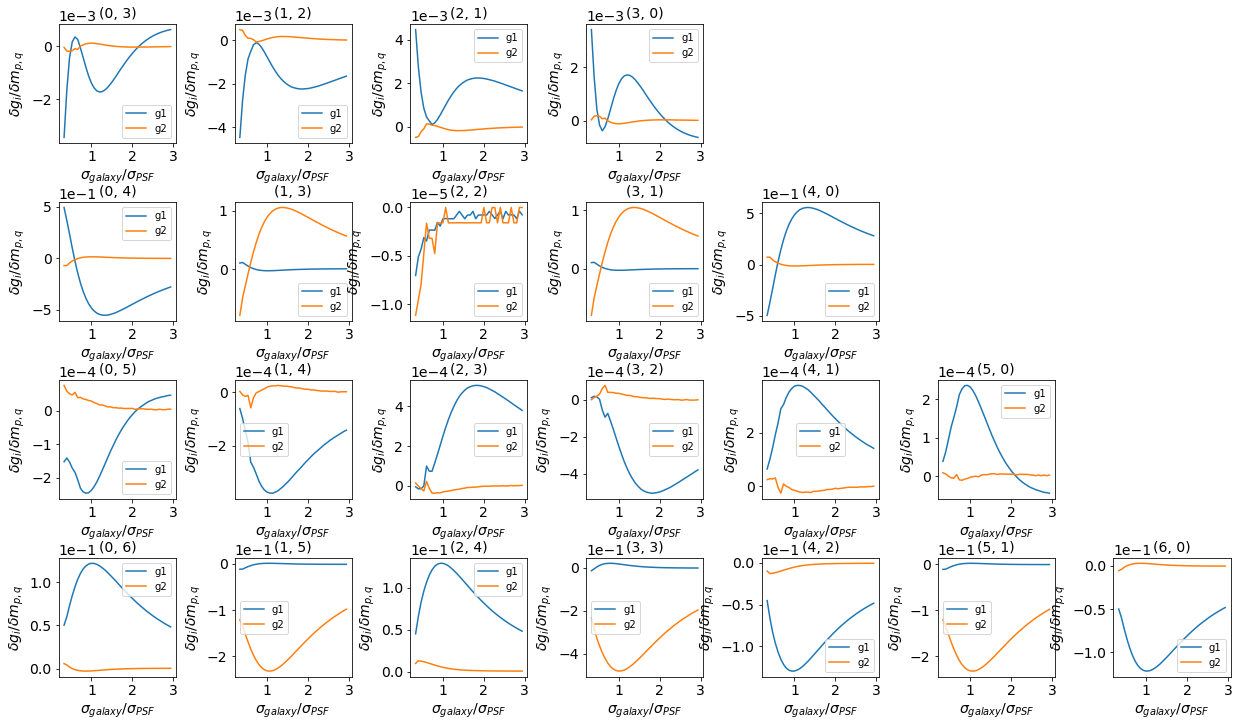

In [27]:
spine_list1 = []
spine_list2 = []
pq4nersc = []


pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    size_ratio = np.array([t['gal_sigma']/t['psf_sigma'] for t in test13result[j]])
    dg1 = np.array([t["abs_bias"][0] for t in test13result[j]])/0.005
    dg2 = np.array([t["abs_bias"][1] for t in test13result[j]])/0.005
    
    plt.plot(size_ratio,dg1,label='g1')
    plt.plot(size_ratio,dg2,label='g2')
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
    
    spine_list1.append(dg1)
    spine_list2.append(dg2)
    pq4nersc.append([p,q])
    
    
    
 
    plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
    plt.ylabel(r'$\delta g_i / \delta m_{p,q}$')
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

In [56]:
np.save('Results/size_ratio.npy',size_ratio)
np.save('Results/dg1.npy',np.array(spine_list1))
np.save('Results/dg2.npy',np.array(spine_list2))
np.save('Results/pq4nersc.npy', np.array(pq4nersc))

In [19]:
test131_init = [("sersic" ,0.5+0.1*i    ,0.1,e2(0.1,0.28),1e-8,1e-8,"gaussian"  ,1.5  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]
test131_m = np.zeros(shape = (22,40,25))
test131_c = np.zeros(shape = (22,40,25))
for index in range(22):
    for i in range(40):
        test131_c[index][i][index+3]+=0.005



In [21]:
test131result = []
for i in range(len(test131_m)):
    print( "Start tests for moment"+ str(i+4))
    test131result.append(do_tests_speed(test131_init,i,test131_m[i],test131_c[i],6))


Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25


In [89]:
test132_init = [("sersic" ,1.0+0.2*i    ,0.1,e2(0.1,0.28),1e-8,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':0.5}) for i in range(40)
]
test132_m = np.zeros(shape = (22,40,25))
test132_c = np.zeros(shape = (22,40,25))
for index in range(22):
    for i in range(40):
        test132_c[index][i][index+3]+=0.005



In [90]:
test132result = []
for i in range(len(test132_m)):
    print "Start tests for moment"+ str(i+4)
    test132result.append(do_tests_speed(test132_init,i,test132_m[i],test132_c[i],6))


Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25


In [10]:
%store test13result
%store test131result
%store test132result

UsageError: Unknown variable 'test13result'


In [11]:
%store -r test13result
%store -r test131result
%store -r test132result

no stored variable or alias test13result
no stored variable or alias test131result
no stored variable or alias test132result


In [142]:
y_range = {}
for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    
    if n not in y_range.keys():
        y_range[n] = [0,0]
    #print min(min(np.array([t["abs_bias"][0] for t in test13result[j]])/0.005),y_range[n][0])
    y_range[n][0] = min(min(np.array([t["abs_bias"][0] for t in test13result[j]])/0.005)*1.1,y_range[n][0])
    y_range[n][0] = min(min(np.array([t["abs_bias"][1] for t in test13result[j]])/0.005)*1.1,y_range[n][0])
    y_range[n][0] = min(min(np.array([t["abs_bias"][0] for t in test131result[j]])/0.005)*1.1,y_range[n][0])
    y_range[n][0] = min(min(np.array([t["abs_bias"][1] for t in test131result[j]])/0.005)*1.1,y_range[n][0])
    
    y_range[n][1] = max(max(np.array([t["abs_bias"][0] for t in test13result[j]])/0.005)*1.1,y_range[n][1])
    y_range[n][1] = max(max(np.array([t["abs_bias"][1] for t in test13result[j]])/0.005)*1.1,y_range[n][1])
    y_range[n][1] = max(max(np.array([t["abs_bias"][0] for t in test131result[j]])/0.005)*1.1,y_range[n][1])
    y_range[n][1] = max(max(np.array([t["abs_bias"][1] for t in test131result[j]])/0.005)*1.1,y_range[n][1])
    

In [143]:
print y_range

{3: [-0.00419898142244475, 0.0041849271143885175], 4: [-1.0596701776470392, 2.0377742444161715], 5: [-0.0008793000199288499, 0.0008805613070531072], 6: [-0.8677690394843353, 0.22398038603949416]}


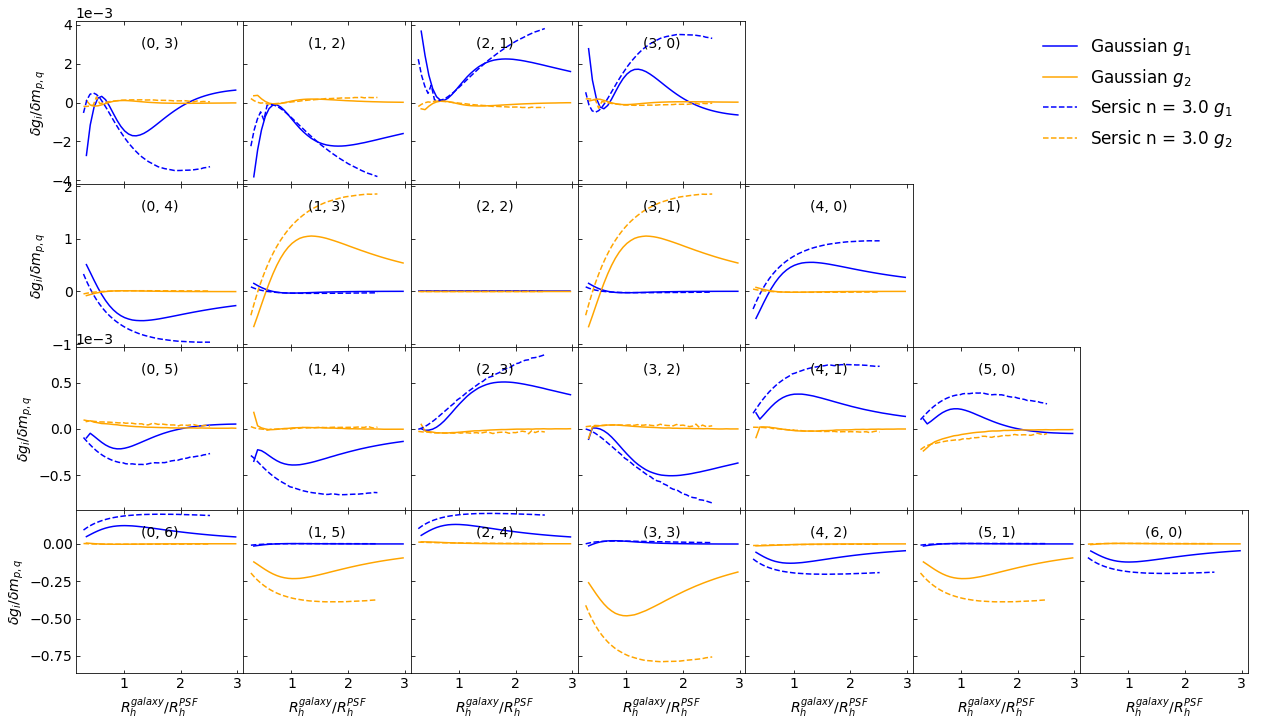

In [144]:


pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

# f, axes = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(21,12))
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)




for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    #print n
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    
    
    plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test13result[j]]),np.array([t["abs_bias"][0] for t in test13result[j]])/0.005,color = 'blue')
    plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test13result[j]]),np.array([t["abs_bias"][1] for t in test13result[j]])/0.005,color = 'orange')

    plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test131result[j]]),np.array([t["abs_bias"][0] for t in test131result[j]])/0.005,'--',color = 'blue')
    plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test131result[j]]),np.array([t["abs_bias"][1] for t in test131result[j]])/0.005,'--',color = 'orange')
    
#     plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test132result[j]]),np.array([t["abs_bias"][0] for t in test131result[j]])/0.005,'.-',color = 'blue')
#     plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test132result[j]]),np.array([t["abs_bias"][1] for t in test131result[j]])/0.005,'.-',color = 'orange')
    
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False)
    
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
    #ax.tick_params(axis="y",direction="in")
    
    
    
    if j in list(range(15,22)):
        plt.xlabel(r"$R_h^{galaxy}/R_h^{PSF}$")
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=True,         # ticks along the top edge are off
            labelbottom=True)
    if j in [0,4,9,15]:
        plt.ylabel(r'$\delta g_i / \delta m_{p,q}$')
        plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            left=True,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=True)
    
    plt.ylim(y_range[n])
    
    plt.title(str((p,q)),y = 0.8)
    #plt.show()
    #plt.legend([])
    

plt.subplot(4,7,7,frame_on = False)
plt.plot([0],[0],color = 'blue',label = r'Gaussian $g_1$')
plt.plot([0],[0],color = 'orange',label = r'Gaussian $g_2$')
plt.plot([0],[0],'--',color = 'blue',label = r'Sersic n = 3.0 $g_1$')
plt.plot([0],[0],'--',color = 'orange',label = r'Sersic n = 3.0 $g_2$')
plt.axis('off')
plt.legend(fontsize = 'large',frameon = False)

    
#fig.colorbar(axes)

In [95]:
print np.array(pq4nersc)

[[0 3]
 [1 2]
 [2 1]
 [3 0]
 [0 4]
 [1 3]
 [2 2]
 [3 1]
 [4 0]
 [0 5]
 [1 4]
 [2 3]
 [3 2]
 [4 1]
 [5 0]
 [0 6]
 [1 5]
 [2 4]
 [3 3]
 [4 2]
 [5 1]
 [6 0]]


In [59]:
def linearity_check(m1, dm1, m2, dm2, config, n_max = 6):
    
    vector_length = (n_max +1 + 3) * (n_max - 1) / 2
    
    test1_m = np.zeros(shape = (1,vector_length))
    test1_c = np.zeros(shape = (1,vector_length))
    test1_c[0][m1]+=dm1
        

    test1 = HOMExShapeletPair(*config[0][:-1],**config[0][-1])
    test1.setup_shapelet_psf(test1_m[0],test1_c[0],n_max)
    results1 = test1.get_results()
            
    test2_m = np.zeros(shape = (1,vector_length))
    test2_c = np.zeros(shape = (1,vector_length))
    test2_c[0][m2]+=dm2
   

    test2 = HOMExShapeletPair(*config[0][:-1],**config[0][-1])
    test2.setup_shapelet_psf(test2_m[0],test2_c[0],n_max)
    results2 = test2.get_results()
    
    
    test3_m = np.zeros(shape = (1,vector_length))
    test3_c = np.zeros(shape = (1,vector_length))
    test3_c[0][m1]+=dm1
    test3_c[0][m2]+=dm2
   

    test3 = HOMExShapeletPair(*config[0][:-1],**config[0][-1])
    test3.setup_shapelet_psf(test3_m[0],test3_c[0],n_max)
    results3 = test3.get_results()
    
    
    dshear1 = results1['abs_bias'][0]
    dshear2 = results2['abs_bias'][0]
    
    
    #print dshear1, dshear2
        
    linear_results = dshear1 + dshear2
    
    auto_results = results3['abs_bias'][0]
    #print results3['actual_dm']
    #print linear_results, auto_results
    
    error_over_minor = abs(linear_results -  auto_results) / min(np.abs(dshear1) , np.abs(dshear2) )
    error_over_sum = abs(linear_results -  auto_results) / (np.abs(dshear1) + np.abs(dshear2))
    
    
    return error_over_minor, error_over_sum
    
    
    
    
    
    

    

In [60]:
config = [("gaussian" ,3.0    ,0.28,0.28,0.001,0.001,"gaussian"  ,2.0 ,{'subtract_intersection':True}) for i in range(1)]


error_over_minor_matrix = np.zeros(shape = (12,12))
error_over_sum_matrix = np.zeros(shape = (12,12))


for i in range(12):
    for j in range(i,12):
        print i,j
        eom, eos = linearity_check(i,0.001,j,0.001,config,4)
        
        error_over_minor_matrix[i][j] = eom
        error_over_sum_matrix[i][j] = eos




0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 6
6 7
6 8
6 9
6 10
6 11
7 7
7 8
7 9
7 10
7 11
8 8
8 9
8 10
8 11
9 9
9 10
9 11
10 10
10 11
11 11


In [61]:
n_max = 4



dg_scale = []
for i in range(12):
    print i
    vector_length = (n_max +1 + 3) * (n_max - 1) / 2
    
    test1_m = np.zeros(shape = (1,vector_length))
    test1_c = np.zeros(shape = (1,vector_length))
    test1_c[0][i]+=0.001
    
    
    test1 = HOMExShapeletPair(*config[0][:-1],**config[0][-1])
    test1.setup_shapelet_psf(test1_m[0],test1_c[0],n_max)
    results1 = test1.get_results()
    dg_scale.append(np.abs(results1['abs_bias'][0]))

0
1
2
3
4
5
6
7
8
9
10
11


Text(0.5,1,'$   \\frac{dg(dm_1) + dg_2(dm_2) - dg(dm_1+dm_2)}{min(dg(dm_1), dg(dm_2))}$')

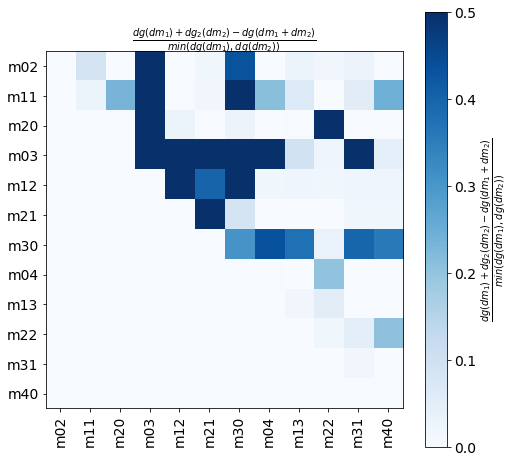

In [62]:
pqlist = test1.sxm.get_pq_full(4)


label_list = []
for i in range(12):

    label_list.append("m"+str(pqlist[i][0])+str(pqlist[i][1])) 
    

fig, ax = plt.subplots(1,1,figsize=(8, 8)) 
mappable = ax.imshow(error_over_minor_matrix, cmap = 'Blues',vmin = -0.0, vmax = 0.5)

# Set number of ticks for x-axis
# Set ticks labels for x-axis
ax.set_xticks(np.arange(0,12,1))
ax.set_yticks(np.arange(0,12,1))

ax.set_xticklabels(label_list, rotation='vertical', fontsize=14)
ax.set_yticklabels(label_list, rotation='horizontal', fontsize=14)

plt.colorbar(mappable, ax = ax, label = r"$   \frac{dg(dm_1) + dg_2(dm_2) - dg(dm_1+dm_2)}{min(dg(dm_1), dg(dm_2))}$")

plt.title(r"$   \frac{dg(dm_1) + dg_2(dm_2) - dg(dm_1+dm_2)}{min(dg(dm_1), dg(dm_2))}$")

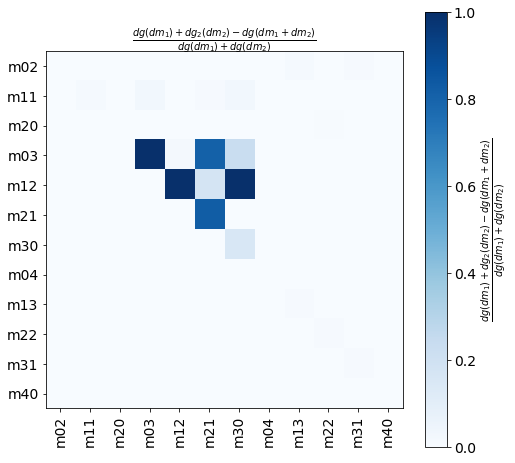

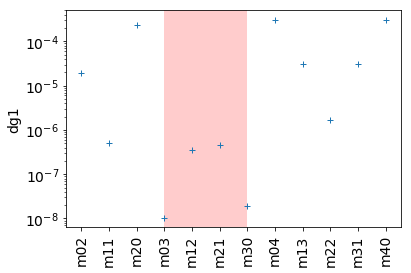

In [63]:
pqlist = test1.sxm.get_pq_full(4)


label_list = []
for i in range(12):

    label_list.append("m"+str(pqlist[i][0])+str(pqlist[i][1])) 
    

fig, ax = plt.subplots(1,1,figsize=(8, 8)) 
mappable = ax.imshow(error_over_sum_matrix, cmap = 'Blues',vmin = -0.0, vmax = 1.0)

# Set number of ticks for x-axis
# Set ticks labels for x-axis
ax.set_xticks(np.arange(0,12,1))
ax.set_yticks(np.arange(0,12,1))

ax.set_xticklabels(label_list, rotation='vertical', fontsize=14)
ax.set_yticklabels(label_list, rotation='horizontal', fontsize=14)

plt.colorbar(mappable, ax = ax, label = r"$   \frac{dg(dm_1) + dg_2(dm_2) - dg(dm_1+dm_2)}{dg(dm_1) +  dg(dm_2)}$")

plt.title(r"$   \frac{dg(dm_1) + dg_2(dm_2) - dg(dm_1+dm_2)}{dg(dm_1) +  dg(dm_2)}$")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(6, 4)) 
mappable = plt.plot(np.arange(0,12), dg_scale,'+')
plt.yscale('log')

ax.axvspan(3, 6, color='r', alpha=0.2, lw=0)

ax.set_xticks(np.arange(0,12,1))
ax.set_xticklabels(label_list, rotation='vertical', fontsize=14)
plt.ylabel('dg1')

plt.show()






In [96]:
print pqlist
pq_for_m = [4,6,8,15,17,19,21]

[(0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]


In [23]:
test14_init = [("gaussian" ,1.0+0.2*i    ,0.1,0.26,1e-8,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True}) for i in range(40)
]
test14_m = np.zeros(shape = (7,40,25))
test14_c = np.zeros(shape = (7,40,25))
for index in range(7):
    for i in range(40):
        test14_c[index][i][pq_for_m[index]+3]+=0.005

        


In [24]:
test14result = []
for i in range(len(test14_m)):
    print "Start tests for moment"+ str(pq_for_m[i]+4)
    test14result.append(do_tests(test14_init,i,test14_m[i],test14_c[i],6))


Start tests for moment8
Start tests for moment10
Start tests for moment12
Start tests for moment19
Start tests for moment21
Start tests for moment23
Start tests for moment25


In [26]:
test141_init = [("gaussian" ,1.0+0.2*i    ,0.1,0.26,0.01,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True}) for i in range(40)
]
test141_m = np.zeros(shape = (7,40,25))
test141_c = np.zeros(shape = (7,40,25))
for index in range(7):
    for i in range(40):
        test141_c[index][i][pq_for_m[index]+3]+=0.005

        


In [28]:
test141result = []
for i in range(len(test141_m)):
    print "Start tests for moment"+ str(pq_for_m[i]+4)
    test141result.append(do_tests(test141_init,i,test141_m[i],test141_c[i],6))


Start tests for moment8
Start tests for moment10
Start tests for moment12
Start tests for moment19
Start tests for moment21
Start tests for moment23
Start tests for moment25


In [29]:
test142_init = [("gaussian" ,1.0+0.2*i    ,0.1,0.26,1e-8,0.01,"gaussian"  ,3.0  ,{'subtract_intersection':True}) for i in range(40)
]
test142_m = np.zeros(shape = (7,40,25))
test142_c = np.zeros(shape = (7,40,25))
for index in range(7):
    for i in range(40):
        test142_c[index][i][pq_for_m[index]+3]+=0.005

        


In [30]:
test142result = []
for i in range(len(test142_m)):
    print "Start tests for moment"+ str(pq_for_m[i]+4)
    test142result.append(do_tests(test142_init,i,test142_m[i],test142_c[i],6))


Start tests for moment8
Start tests for moment10
Start tests for moment12
Start tests for moment19
Start tests for moment21
Start tests for moment23
Start tests for moment25


In [34]:
print test14result[0][0]

{'psf_model_sigma': 3.0, 'dm': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]), 'e': array([0.1 , 0.26]), 'g': array([1.e-08, 1.e-08]), 'e1': 0.1, 'psf_type': 'gaussian', 'gal_sigma': 1.0, 'shear_bias': array([255222.98199803, -39033.30499466]), 'sersicn': -1, 'actual_dm': array([ 1.03797970e-08,  0.00000000e+00,  1.76054180e-08,  5.77835363e-10,
       -7.85419443e-10, -8.74821059e-11, -4.55580243e-09,  4.99999366e-03,
        1.33735404e-09, -2.68925734e-09,  1.03597274e-09, -8.66008476e-09,
       -3.56848786e-09, -2.26291081e-09,  4.80992169e-10, -1.75070666e-09,
        1.66981793e-09, -1.52094682e-08, -1.71839722e-08,  6.73515182e-09,
       -3.11652765e-09,  3.73261904e-09, -1.32973205e-09,  5.69094617e-09,
       -5.65126790e-09]), 'e2': 0.26, 'abs_bias': array([ 0.00255223, -0.00039033]), 'psf_sigma': 3.0, 'gal_type': 'gaussian'}


In [43]:
size_ratio = np.zeros(shape = (40))
m1_size = np.zeros(shape = (7,40))
m2_size = np.zeros(shape = (7,40))

for i in range(40):
    size_ratio[i] = test14result[0][i]['gal_sigma']/test14result[0][i]['psf_sigma']
    for j in range(7):
        m1_size[j][i] = (test141result[j][i]['abs_bias'][0] - test14result[j][i]['abs_bias'][0])/0.01/0.005
        m2_size[j][i] = (test142result[j][i]['abs_bias'][1] - test14result[j][i]['abs_bias'][1])/0.01/0.005

In [49]:
print m1_size.shape

(7, 40)


In [48]:
np.save('data/multiplicative_size_ratio',size_ratio)
np.save('data/m1_size_ratio',m1_size)
np.save('data/m2_size_ratio',m2_size)


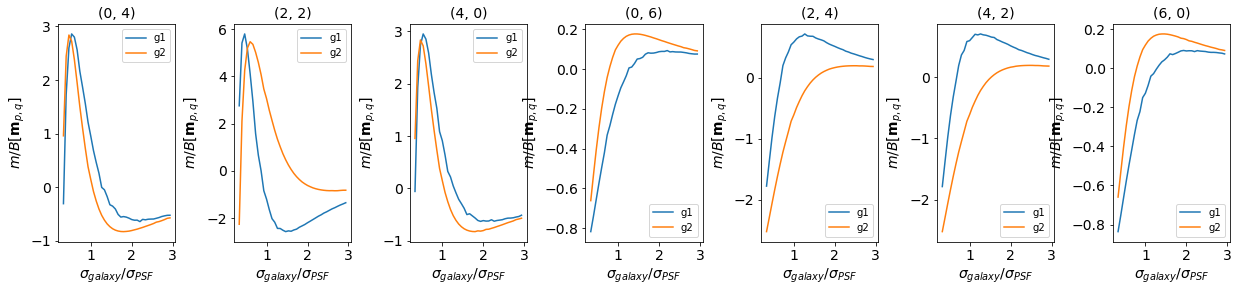

In [58]:

fig = plt.figure(figsize = (21,4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for j in range(7):
    p,q = pqlist[pq_for_m[j]][0],pqlist[pq_for_m[j]][1]
    n = p+q
    ax = plt.subplot(1,7,j+1)
    
    m1 = m1_size[j]
    m2 = m2_size[j]
    
    
    plt.plot(size_ratio,m1,label='g1')
    plt.plot(size_ratio,m2,label='g2')
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
    

    
 
    plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
    plt.ylabel(r'$ m / B[ \mathbf{m}_{p,q}]$')
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

In [97]:
test15_init = [("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':0.5}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,0.01,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':0.5}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,0.01,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':0.5}) for i in range(40)
]
test15_m = np.zeros(shape = (7,120,25))
test15_c = np.zeros(shape = (7,120,25))
for index in range(7):
    for i in range(120):
        test15_c[index][i][pq_for_m[index]+3]+=0.005

        


In [100]:
test15result = []
for i in range(len(test15_m)):
    print "Start tests for moment"+ str(pq_for_m[i]+4)
    test15result.append(do_tests(test15_init,i,test15_m[i],test15_c[i],6))


Start tests for moment8
Start tests for moment10
Start tests for moment12
Start tests for moment19
Start tests for moment21
Start tests for moment23
Start tests for moment25


In [101]:
test151_init = [("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,0.01,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,0.01,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]
test151_m = np.zeros(shape = (7,120,25))
test151_c = np.zeros(shape = (7,120,25))
for index in range(7):
    for i in range(120):
        test151_c[index][i][pq_for_m[index]+3]+=0.005

        


In [102]:
test151result = []
for i in range(len(test151_m)):
    print "Start tests for moment"+ str(pq_for_m[i]+4)
    test151result.append(do_tests(test151_init,i,test151_m[i],test151_c[i],6))


Start tests for moment8
Start tests for moment10
Start tests for moment12
Start tests for moment19
Start tests for moment21
Start tests for moment23
Start tests for moment25


In [126]:
size_ratio_gau = np.zeros(shape = (40))
m1_size_gau = np.zeros(shape = (7,40))
m2_size_gau = np.zeros(shape = (7,40))

for i in range(40):
    size_ratio_gau[i] = test15result[0][i]['gal_hlr']/test15result[0][i]['psf_hlr']
    for j in range(7):
        m1_size_gau[j][i] = (test15result[j][i+40]['abs_bias'][0] - test15result[j][i]['abs_bias'][0])/0.01/0.005
        m2_size_gau[j][i] = (test15result[j][i+80]['abs_bias'][1] - test15result[j][i]['abs_bias'][1])/0.01/0.005

In [127]:
size_ratio_ser = np.zeros(shape = (40))
m1_size_ser = np.zeros(shape = (7,40))
m2_size_ser = np.zeros(shape = (7,40))

for i in range(40):
    size_ratio_ser[i] = test151result[0][i]['gal_hlr']/test151result[0][i]['psf_hlr']
    for j in range(7):
        m1_size_ser[j][i] = (test151result[j][i+40]['abs_bias'][0] - test151result[j][i]['abs_bias'][0])/0.01/0.005
        m2_size_ser[j][i] = (test151result[j][i+80]['abs_bias'][1] - test151result[j][i]['abs_bias'][1])/0.01/0.005

In [133]:
y_range_15 = {}
for j in range(7):
    p,q = pqlist[pq_for_m[j]][0],pqlist[pq_for_m[j]][1]
    n = p+q
    
    if n not in y_range_15.keys():
        y_range_15[n] = [0,0]
    #print min(min(np.array([t["abs_bias"][0] for t in test13result[j]])/0.005),y_range[n][0])
    y_range_15[n][0] = min(min(m1_size_gau[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m2_size_gau[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m1_size_ser[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m2_size_ser[j]*1.1),y_range_15[n][0])
    
    y_range_15[n][1] = max(max(m1_size_gau[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m2_size_gau[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m1_size_ser[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m2_size_ser[j]*1.1),y_range_15[n][1])
    

In [134]:
print y_range_15

{4: [-9.013574836905375, 9.630237314208811], 6: [-3.174831989688543, 0.9909569859789872]}


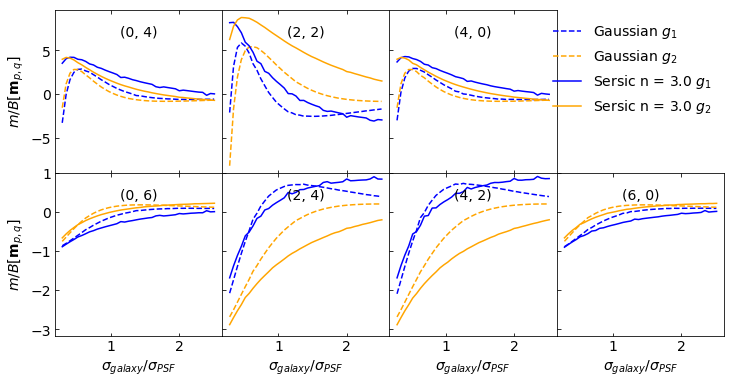

In [141]:

fig = plt.figure(figsize = (12,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for j in range(7):
    p,q = pqlist[pq_for_m[j]][0],pqlist[pq_for_m[j]][1]
    n = p+q
    
    position = 1+j
    if j>2: position = 2+j
    ax = plt.subplot(2,4,position)
    
    
    
    plt.plot(size_ratio_gau,m1_size_gau[j],'--',color = 'blue',label = r'Gaussian $g_1$')
    plt.plot(size_ratio_gau,m2_size_gau[j],'--',color = 'orange',label = r'Gaussian $g_2$')
    
    plt.plot(size_ratio_ser,m1_size_ser[j],color = 'blue',label = r'Sersic n=3 $g_1$')
    plt.plot(size_ratio_ser,m2_size_ser[j],color = 'orange',label = r'Sersic n=3 $g_2$')
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))
    
        
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False)
    
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
    #ax.tick_params(axis="y",direction="in")
    
    
    
    if j in list(range(3,7)):
        plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=True,         # ticks along the top edge are off
            labelbottom=True)
    if j in [0,3]:
        plt.ylabel(r'$ m / B[ \mathbf{m}_{p,q}]$')
        plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            left=True,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=True)
    
    plt.ylim(y_range_15[n])

    #plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
    #plt.ylabel(r'$ m / B[ \mathbf{m}_{p,q}]$')
    
    plt.title(str((p,q)),y = 0.8)
    #plt.show()
    #plt.legend()
    
plt.subplot(2,4,4,frame_on = False)
plt.plot([0],[0],'--',color = 'blue',label = r'Gaussian $g_1$')
plt.plot([0],[0],'--',color = 'orange',label = r'Gaussian $g_2$')
plt.plot([0],[0],color = 'blue',label = r'Sersic n = 3.0 $g_1$')
plt.plot([0],[0],color = 'orange',label = r'Sersic n = 3.0 $g_2$')
plt.axis('off')
plt.legend(fontsize = 'medium',frameon = False)


In [3]:
psf = galsim.Gaussian(sigma = 1.0)
image = psf.drawImage(scale = 0.1,method = 'no_pixel')
FWHM = psf.calculateFWHM()

In [4]:
print FWHM

2.35482004503


In [5]:
0.5*2.35

1.175

In [6]:
0.3*2.35

0.705

In [7]:
0.7*2.35

1.645

In [8]:
0.4*2.35

0.9400000000000001

In [9]:
1.5*2.23

3.3449999999999998

In [79]:
test17_init = [("gaussian" ,0.5+0.1*i    ,0.1,0.26,1e-8,1e-8,"gaussian"  ,1.5 ,{'subtract_intersection':True}) for i in range(40)
]+[("gaussian" ,0.5+0.1*i    ,0.1,0.26,0.01,1e-8,"gaussian"  ,1.5 ,{'subtract_intersection':True}) for i in range(40)
]+[("gaussian" ,0.5+0.1*i    ,0.1,0.26,1e-8,0.01,"gaussian"  ,1.5 ,{'subtract_intersection':True}) for i in range(40)
]
test17_m = np.zeros(shape = (22,120,25))
test17_c = np.zeros(shape = (22,120,25))
for index in range(22):
    for i in range(120):
        test17_c[index][i][index+3]+=0.005

        


In [80]:
test17result = []
for i in range(len(test17_m)):
    print( "Start tests for moment"+ str(i+4))
    test17result.append(do_tests_speed(test17_init,i,test17_m[i],test17_c[i],6))


Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25


In [37]:
size_ratio_gau = np.zeros(shape = (40))
m1_size_gau = np.zeros(shape = (22,40))
m2_size_gau = np.zeros(shape = (22,40))

for i in range(40):
    size_ratio_gau[i] = test17result[0][i]['gal_hlr']/test17result[0][i]['psf_hlr']
    for j in range(22):
        m1_size_gau[j][i] = (test17result[j][i+40]['abs_bias'][0] - test17result[j][i]['abs_bias'][0])/0.01/0.005
        m2_size_gau[j][i] = (test17result[j][i+80]['abs_bias'][1] - test17result[j][i]['abs_bias'][1])/0.01/0.005

In [90]:
size_ratio_ser = np.zeros(shape = (40))
m1_size_ser = np.zeros(shape = (22,40))
m2_size_ser = np.zeros(shape = (22,40))

for i in range(40):
    size_ratio_ser[i] = test171result[0][i]['gal_hlr']/test171result[0][i]['psf_hlr']
    for j in range(22):
        m1_size_ser[j][i] = (test171result[j][i+40]['abs_bias'][0] - test171result[j][i]['abs_bias'][0])/0.01/0.005
        m2_size_ser[j][i] = (test171result[j][i+80]['abs_bias'][1] - test171result[j][i]['abs_bias'][1])/0.01/0.005

In [91]:
y_range_15 = {}
for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    
    if n not in y_range_15.keys():
        y_range_15[n] = [0,0]
    #print min(min(np.array([t["abs_bias"][0] for t in test13result[j]])/0.005),y_range[n][0])
    y_range_15[n][0] = min(min(m1_size_gau[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m2_size_gau[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m1_size_ser[j]*1.1),y_range_15[n][0])
    y_range_15[n][0] = min(min(m2_size_ser[j]*1.1),y_range_15[n][0])
    
    y_range_15[n][1] = max(max(m1_size_gau[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m2_size_gau[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m1_size_ser[j]*1.1),y_range_15[n][1])
    y_range_15[n][1] = max(max(m2_size_ser[j]*1.1),y_range_15[n][1])
    

In [93]:
with open("../plots2/pickle/mul_size_ratio.pkl","wb") as f:
    pickle.dump([pqlist,test17result,test171result ],f)

In [36]:
with open('../plots2/pickle/mul_size_ratio.pkl','rb') as f:
    pqlist,test17result,test171result = pickle.load(f)

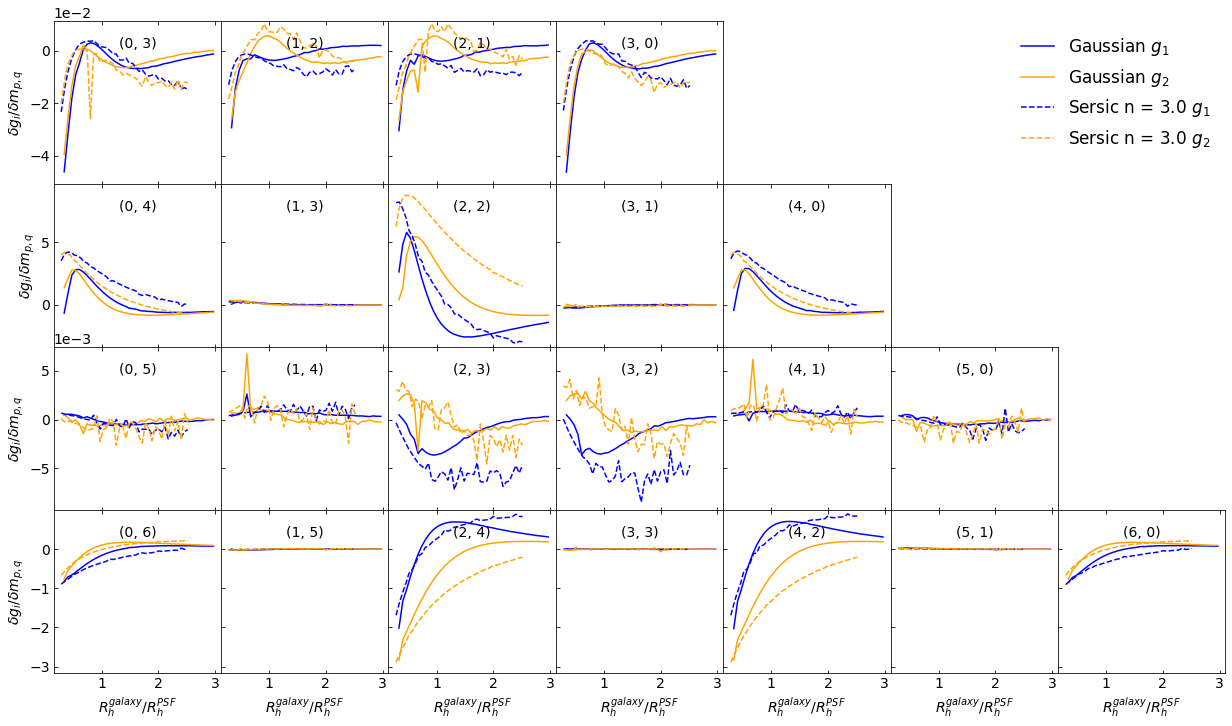

In [92]:


pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

# f, axes = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(21,12))
# f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)




for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    #print n
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    
    
    
    
    plt.plot(size_ratio_gau,m1_size_gau[j],color = 'blue',label = r'Gaussian $g_1$')
    plt.plot(size_ratio_gau,m2_size_gau[j],color = 'orange',label = r'Gaussian $g_2$')
    
    plt.plot(size_ratio_ser,m1_size_ser[j],'--',color = 'blue',label = r'Gaussian $g_1$')
    plt.plot(size_ratio_ser,m2_size_ser[j],'--',color = 'orange',label = r'Gaussian $g_2$')
    
#     plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test132result[j]]),np.array([t["abs_bias"][0] for t in test131result[j]])/0.005,'.-',color = 'blue')
#     plt.plot(np.array([t['gal_hlr']/t['psf_hlr'] for t in test132result[j]]),np.array([t["abs_bias"][1] for t in test131result[j]])/0.005,'.-',color = 'orange')
    
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False)
    
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        direction = 'in',
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
    #ax.tick_params(axis="y",direction="in")
    
    
    
    if j in list(range(15,22)):
        plt.xlabel(r"$R_h^{galaxy}/R_h^{PSF}$")
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=True,         # ticks along the top edge are off
            labelbottom=True)
    if j in [0,4,9,15]:
        plt.ylabel(r'$\delta g_i / \delta m_{p,q}$')
        plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            direction = 'in',
            which='both',      # both major and minor ticks are affected
            left=True,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=True)
    
    plt.ylim(y_range_15[n])
    
    plt.title(str((p,q)),y = 0.8)
    #plt.show()
    #plt.legend([])
    

plt.subplot(4,7,7,frame_on = False)
plt.plot([0],[0],color = 'blue',label = r'Gaussian $g_1$')
plt.plot([0],[0],color = 'orange',label = r'Gaussian $g_2$')
plt.plot([0],[0],'--',color = 'blue',label = r'Sersic n = 3.0 $g_1$')
plt.plot([0],[0],'--',color = 'orange',label = r'Sersic n = 3.0 $g_2$')
plt.axis('off')
plt.legend(fontsize = 'large',frameon = False)

    
#fig.colorbar(axes)

In [88]:
test171_init = [("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,0.01,1e-8,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]+[("sersic" ,1.0+0.2*i    ,0.1,0.26,1e-8,0.01,"gaussian"  ,3.0  ,{'subtract_intersection':True,'sersicn':3.0}) for i in range(40)
]
test171_m = np.zeros(shape = (22,120,25))
test171_c = np.zeros(shape = (22,120,25))
for index in range(22):
    for i in range(120):
        test171_c[index][i][index+3]+=0.005

        


In [89]:
test171result = []
for i in range(len(test171_m)):
    print( "Start tests for moment"+ str(i+4))
    test171result.append(do_tests_speed(test171_init,i,test171_m[i],test171_c[i],6))


Start tests for moment4
Start tests for moment5
Start tests for moment6
Start tests for moment7
Start tests for moment8
Start tests for moment9
Start tests for moment10
Start tests for moment11
Start tests for moment12
Start tests for moment13
Start tests for moment14
Start tests for moment15
Start tests for moment16
Start tests for moment17
Start tests for moment18
Start tests for moment19
Start tests for moment20
Start tests for moment21
Start tests for moment22
Start tests for moment23
Start tests for moment24
Start tests for moment25


In [60]:
size_ratio_cosmos = np.load('data/size_ratio_array.npy')
size_ratio_cosmos = size_ratio_cosmos[size_ratio_cosmos<2.9]

In [57]:
print(size_ratio_gau)

[0.33745993 0.40495192 0.4724439  0.53993589 0.60742788 0.67491986
 0.74241185 0.80990384 0.87739582 0.94488781 1.01237979 1.07987178
 1.14736377 1.21485575 1.28234774 1.34983973 1.41733171 1.4848237
 1.55231568 1.61980767 1.68729966 1.75479164 1.82228363 1.88977562
 1.9572676  2.02475959 2.09225158 2.15974356 2.22723555 2.29472753
 2.36221952 2.42971151 2.49720349 2.56469548 2.63218747 2.69967945
 2.76717144 2.83466342 2.90215541 2.9696474 ]


In [68]:
HSC_moment_bias = np.load('data/mean_residual.npy')


In [72]:
from scipy import interpolate

g1_m = []; g2_m = []

for i in range(22):
#     this_f1 = interpolate.LinearNDInterpolator(x, dg1[i])
#     this_f2 = interpolate.LinearNDInterpolator(x, dg2[i])

    
    this_f1 = interpolate.interp1d(size_ratio_gau, m1_size_gau[i])
    m1 = this_f1(size_ratio_cosmos)
    g1_m.append(np.mean(m1) * HSC_moment_bias[i+3])
    
    this_f2 = interpolate.interp1d(size_ratio_gau, m2_size_gau[i])
    m2 = this_f2(size_ratio_cosmos)
    g2_m.append(np.mean(m2)  * HSC_moment_bias[i+3]   )

m1 = 0.0016573327660325226
m2 = 0.001904759081268243


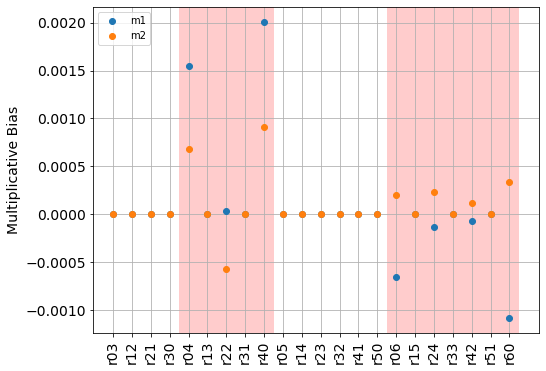

In [75]:
nob = 50

label_list = []
pqlist = test1.sxm.get_pq_full(6)
for i in range(nob):
    if i < 25:
        i_pre = 't'
        
    else:
        i_pre = 'r'
        
    
    label1 = i_pre+str(pqlist[i%25][0])+str(pqlist[i%25][1])
    label_list.append(label1)

fig, ax = plt.subplots(1,1,figsize=(8, 6)) 
ax.plot(np.arange(3,25),g1_m,'o',label = 'm1')
ax.plot(np.arange(3,25),g2_m,'o',label = 'm2')

ax.axvspan(6.5, 11.5, color='r', alpha=0.2, lw=0)

ax.axvspan(17.5, 24.5, color='r', alpha=0.2, lw=0)


ax.set_xticks(np.arange(3,25,1))
ax.set_xticklabels(label_list[28:], rotation='vertical', fontsize=14)

plt.grid()
plt.legend()
plt.ylabel("Multiplicative Bias")




print( "m1 = " + str(np.sum(g1_m)))
print( "m2 = " + str(np.sum(g2_m)))

In [76]:
import pickle

    with open("../plots2/pickle/mul_prelim.pkl","wb") as f:
        pickle.dump([g1_m,g2_m,label_list ],f)

In [25]:
psf = galsim.Gaussian(sigma = 1.5)
image = psf.drawImage(scale = 1.0, method = 'no_pixel')
print(image.calculateFWHM()*0.2)

0.7722478503849612


In [42]:
pixel_size = [0.1,0.15, 0.2,0.25, 0.3]
#gal_size = 0.17 arcsec, psf_size = 0.24 arcsec, pixel_size = 0.2 arcsec
test18_init = [("gaussian" ,0.5/this_pixel    ,0.28,0.28,1e-8,1e-8,"gaussian"  ,0.3/this_pixel ,{'subtract_intersection':True}) for this_pixel in pixel_size
]

test18_m = np.zeros(shape = (22,5,25))
test18_c = np.zeros(shape = (22,5,25))
for index in range(22):
    for i in range(5):
        #test3_c[index][i][index+3]+=HSC_moment_bias[index+3]
        test18_c[index][i][index+3]+=0.01



In [43]:
test18result = []
for i in range(len(test18_m)):
    print( "Start tests for moment"+ str(i+4))
    test18result.append(do_tests(test18_init,i,test18_m[i],test18_c[i],6))
 

Finished 100.0%


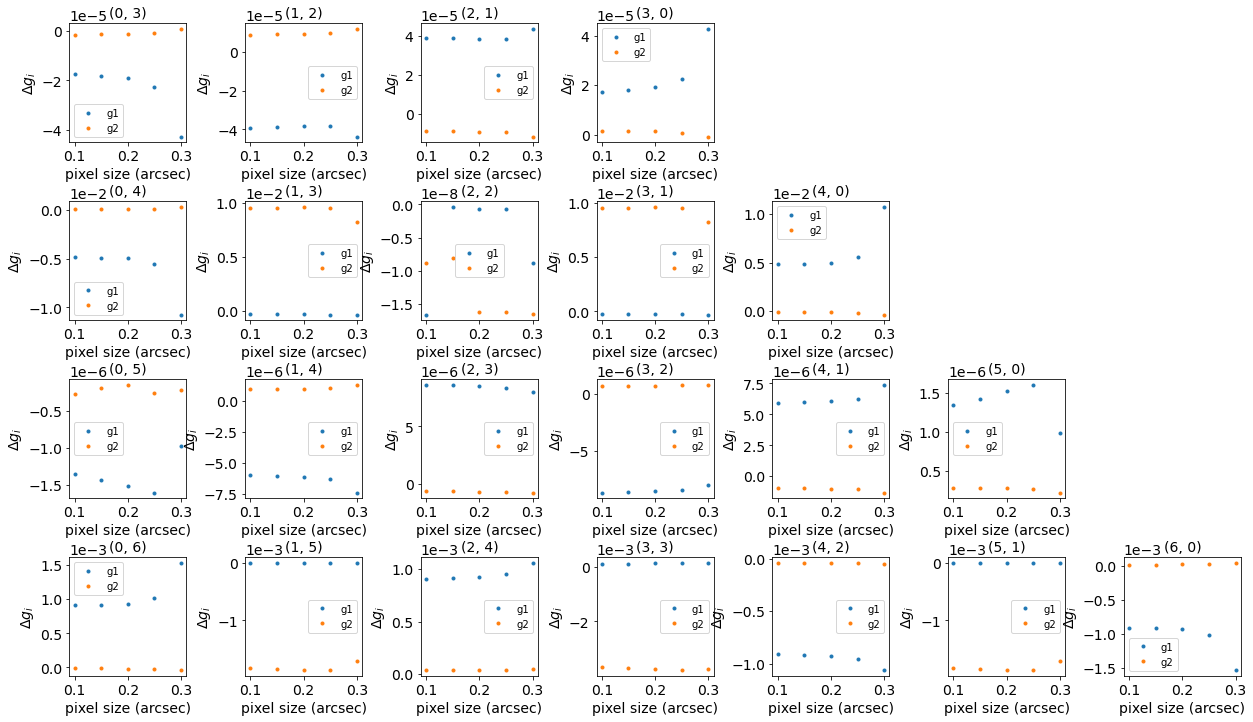

In [45]:
pqlist = test1.sxm.get_pq_full(6)[3:]
fig = plt.figure(figsize = (21,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)



for j in range(22):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(4,7,1+7*(n-3)+p)
    

    
    dg1 = np.array([t["abs_bias"][0] for t in test18result[j]])
    dg2 = np.array([t["abs_bias"][1] for t in test18result[j]])
    

    
    plt.plot(pixel_size,dg1,'.',label='g1')
    plt.plot(pixel_size,dg2,'.',label='g2')

    
    
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,3))

    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    plt.xlabel(r"pixel size (arcsec)")
    plt.ylabel(r'${\Delta g_i}$')
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)